In [1]:
import torch
import os
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import random
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import wandb
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Проверяем - установлен ли Torch с CUDA (чтобы обучать на GPU)
torch.cuda.is_available()

True

In [3]:
# Устанавливаем seed для воспроизводимости результатов
seed = 42
torch.manual_seed(seed)
random.seed(seed)

In [4]:
# Для загрузки изображений была использована библиотека
# https://github.com/hardikvasa/google-images-download 

In [5]:
# Датасет должен иметь такой формат хранения
# dataset/
  # └── apple/
  #     ├── apple_image1.jpg
  #     ├── apple_image2.jpg
  #     └── ...
  # └── banana/
  #     ├── banana_image1.jpg
  #     ├── banana_image2.jpg
  #     └── ...
  # └── ...

In [6]:
# Напишем класс для CNN-моделей

In [7]:
class CNNModel:
    def __init__(self,
                 dataset_path,
                 train_size=0.8,
                 test_size=0.1,
                 val_size=0.1,
                 imgsz=(224,224),
                 batch_size = 32,
                 shuffle = True,
                 norm_mean_rgb=(0.485, 0.456, 0.406), 
                 norm_std_rgb=(0.229, 0.224, 0.225),
                 custom_model=None,
                 pretrained_model=models.vgg16,
                 pretrained=True,
                 device="0",
                 use_wandb=True,
                 wandb_project="CNNModels",
                 experiment_name="Test"):

        self.use_wandb = use_wandb
        self.wandb_project = wandb_project
        self.experiment_name = experiment_name
        self.batch_size = batch_size
        self.train_size = train_size
        self.test_size = test_size
        self.val_size = val_size
        self.shuffle = shuffle
        self.dataset_path = dataset_path
        self.imgsz = imgsz
        self.norm_mean_rgb = norm_mean_rgb
        self.norm_std_rgb = norm_std_rgb
        self.device = torch.device("cpu" if device=="cpu" else f"cuda:{device}")
        if not torch.cuda.is_available() and self.device != "cpu":
            raise(f"torch.cuda.is_available(): {torch.cuda.is_available()}, check CUDA or set param device='cpu'")
        if self.use_wandb:
            wandb.init(project=self.wandb_project, name=self.experiment_name)


        self.dataset = self.get_dataset(self.dataset_path)
        self.model = self.create_architecture(custom_model, pretrained_model, pretrained)
        self.criterion=torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001)

        self.num_imgs = len(self.dataset.imgs)

    
    def create_architecture(self, custom_model, pretrained_model_arch, pretrained):
        if custom_model is None and pretrained_model_arch is None:
            raise("Error with model. Please put pretrained_model or custom_model")
        
        if custom_model:
            model = custom_model.to(self.device)
            return model
        
        self.num_classes = len(self.dataset.classes)
        
        # Загрузка предварительно обученной модели
        model = pretrained_model_arch(pretrained=pretrained)
        try:
            model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, self.num_classes)
        except AttributeError:  # ResNet-50
            model.fc = torch.nn.Linear(model.fc.in_features, self.num_classes)
        
        # Замораживаем веса всех слоев, кроме последнего
        for param in model.parameters():
            param.requires_grad = False
        try:
            model.classifier[-1].weight.requires_grad = True
            model.classifier[-1].bias.requires_grad = True
        except AttributeError:  # ResNet-50
            model.fc.weight.requires_grad = True
            model.fc.bias.requires_grad = True

        # Перемещение модели на GPU
        model = model.to(self.device)

        return model


    
    def train(self, num_epochs=5, batch_size=None, loss=torch.nn.CrossEntropyLoss(), optimizer=torch.optim.SGD, lr=0.001, finish_train=True):
        if batch_size is None:
            batch_size = self.batch_size
            
        train_loader, test_loader, valid_loader = self.get_DataLoader(batch_size)
        optimizer = optimizer(self.model.parameters(), lr=lr)
        criterion = loss
        device = self.device

        for epoch in range(num_epochs):
            self.model.train()  # Установим модель в режим обучения
            current_img = 0
            for images, labels in train_loader:
                current_img += batch_size
                print(f"Training {current_img}/{int(self.num_imgs*self.train_size)} imgs of epoch {epoch+1}")
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss = loss.item()
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        
            # Оценка на тестовой выборке
            self.model.eval()  # Установим модель в режим оценки
            all_preds, all_labels = [], []
            test_loss = 0.0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = self.model(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.tolist())
                    all_labels.extend(labels.tolist())
        
            # Вычисление метрик
            precision = precision_score(all_labels, all_preds, average='weighted')
            recall = recall_score(all_labels, all_preds, average='weighted')
            f1 = f1_score(all_labels, all_preds, average='weighted')
            accuracy = accuracy_score(all_labels, all_preds)
        
            print(f'Test Metrics - Precision: {precision}, Recall: {recall}, F1: {f1}, Accuracy: {accuracy}')
            if self.use_wandb:
                # Логирование потерь и метрик для тестового набора данных
                wandb.log({"Train Loss": train_loss, 
                           "Test Loss": test_loss / len(test_loader), 
                           "Test Precision": precision, 
                           "Test Recall": recall, 
                           "Test F1": f1, 
                           "Test Accuracy": accuracy})
        if finish_train:
            if self.use_wandb:
                wandb.finish()

    def predict(self, file_path):
        image = Image.open(file_path).convert('RGB')
        transform = self.get_transform()
        input_image = transform(image).unsqueeze(0)
        # Перемещение входного изображения на устройство (GPU или CPU)
        input_image = input_image.to(self.device)
        # Установка модели в режим оценки
        self.model.eval()
        # Предсказание класса
        with torch.no_grad():
            output = self.model(input_image)
            _, predicted_class = torch.max(output, 1)
        # Получение названия предсказанного класса
        class_index = predicted_class.item()
        class_name = self.dataset.classes[class_index]

        return class_name

    def get_DataLoader(self, batch_size, num_workers=4, pin_memory=True):
        train_dataset, test_dataset, valid_dataset = self.split_train_test_val()
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=self.shuffle, pin_memory=pin_memory, num_workers=num_workers)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)
        
        return train_loader, test_loader, valid_loader
    
    
    def split_train_test_val(self):
        train_dataset, test_dataset, valid_dataset = random_split(self.dataset, [self.train_size, self.test_size, self.val_size])
        return train_dataset, test_dataset, valid_dataset
        
    
    def get_dataset(self, dataset_path):
        dataset = ImageFolder(root=dataset_path, transform=self.get_transform())
        return dataset

    # функция возвращает трансформер для изображений
    def get_transform(self):
        transform = transforms.Compose([
            transforms.Resize(self.imgsz),
            transforms.ToTensor(),
            transforms.Normalize(self.norm_mean_rgb, self.norm_std_rgb)
        ])
        return transform

In [8]:
VGG16_model = CNNModel(dataset_path="Data/all_data/", pretrained_model=models.vgg16, experiment_name="vgg16")

wandb: Currently logged in as: hezonar (zxcpewpew). Use `wandb login --relogin` to force relogin


C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
VGG16_model.train(num_epochs=50)

Training 32/2055 imgs of epoch 1
Training 64/2055 imgs of epoch 1
Training 96/2055 imgs of epoch 1
Training 128/2055 imgs of epoch 1
Training 160/2055 imgs of epoch 1
Training 192/2055 imgs of epoch 1
Training 224/2055 imgs of epoch 1
Training 256/2055 imgs of epoch 1
Training 288/2055 imgs of epoch 1
Training 320/2055 imgs of epoch 1
Training 352/2055 imgs of epoch 1
Training 384/2055 imgs of epoch 1
Training 416/2055 imgs of epoch 1
Training 448/2055 imgs of epoch 1
Training 480/2055 imgs of epoch 1
Training 512/2055 imgs of epoch 1
Training 544/2055 imgs of epoch 1
Training 576/2055 imgs of epoch 1
Training 608/2055 imgs of epoch 1
Training 640/2055 imgs of epoch 1
Training 672/2055 imgs of epoch 1
Training 704/2055 imgs of epoch 1
Training 736/2055 imgs of epoch 1
Training 768/2055 imgs of epoch 1
Training 800/2055 imgs of epoch 1
Training 832/2055 imgs of epoch 1
Training 864/2055 imgs of epoch 1
Training 896/2055 imgs of epoch 1
Training 928/2055 imgs of epoch 1
Training 960/2055

Test Accuracy,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
Test F1,▁▄▆▆▇▇▇▇▇███████████████████████████████
Test Loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Precision,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
Test Recall,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
Train Loss,██▆▆▆▆▅▃▅▂▄▃▃▂▄▄▂▃▁▃▄▂▃█▄▂▂▂▂▁▃▂▃▄▄▁▅▂▃▁
Test Accuracy,0.91829
Test F1,0.91869
Test Loss,0.28902
Test Precision,0.92486
Test Recall,0.91829


In [17]:
def predict_show_img(img_path, model):
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print("Predicted class: ", model.predict(img_path))

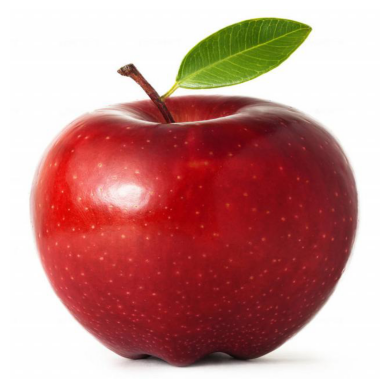

Predicted class:  apple


In [18]:
predict_show_img("Data/all_data/apple/Image_1_jpg.rf.732892aeec52ea8540ee77900a7d7080.jpg", VGG16_model)

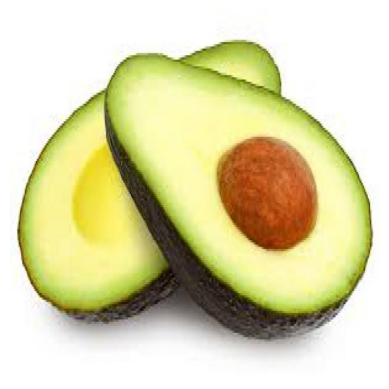

Predicted class:  avocado


In [19]:
predict_show_img("Data/all_data/avocado/img_1421_jpeg.rf.293068ecc7ddcb7787d9793b2a757ec8.jpg", VGG16_model)

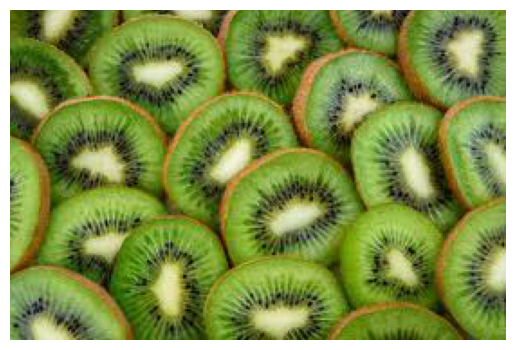

Predicted class:  kiwi


In [20]:
predict_show_img("C:/Users/KK/Downloads/qiwi_random.jfif", VGG16_model)   # скачанная только что (не было в датасете)

In [21]:
VGG19_model = CNNModel(dataset_path="Data/all_data/", pretrained_model=models.vgg19, experiment_name="vgg19")
VGG19_model.train(num_epochs=50)

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\KK/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
4.3%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.


Training 32/2055 imgs of epoch 1
Training 64/2055 imgs of epoch 1
Training 96/2055 imgs of epoch 1
Training 128/2055 imgs of epoch 1
Training 160/2055 imgs of epoch 1
Training 192/2055 imgs of epoch 1
Training 224/2055 imgs of epoch 1
Training 256/2055 imgs of epoch 1
Training 288/2055 imgs of epoch 1
Training 320/2055 imgs of epoch 1
Training 352/2055 imgs of epoch 1
Training 384/2055 imgs of epoch 1
Training 416/2055 imgs of epoch 1
Training 448/2055 imgs of epoch 1
Training 480/2055 imgs of epoch 1
Training 512/2055 imgs of epoch 1
Training 544/2055 imgs of epoch 1
Training 576/2055 imgs of epoch 1
Training 608/2055 imgs of epoch 1
Training 640/2055 imgs of epoch 1
Training 672/2055 imgs of epoch 1
Training 704/2055 imgs of epoch 1
Training 736/2055 imgs of epoch 1
Training 768/2055 imgs of epoch 1
Training 800/2055 imgs of epoch 1
Training 832/2055 imgs of epoch 1
Training 864/2055 imgs of epoch 1
Training 896/2055 imgs of epoch 1
Training 928/2055 imgs of epoch 1
Training 960/2055

Test Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇█▇▇▇▇█▇▇██▇█▇▇██▇██████▇████
Test F1,▁▄▅▆▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇██▇█▇▇██▇██████▇████
Test Loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Precision,▁▄▅▆▆▆▆▇▇▇▇▇█▇██▇███████████████████████
Test Recall,▁▄▅▆▆▆▆▇▇▇▇▇█▇▇▇▇█▇▇██▇█▇▇██▇██████▇████
Train Loss,██▇▅▇▆▅▆▃▄▂▆▃▆▂▃▃▂▃▃▂█▂▄▄▂▃▁▃▂▄▂▃▁▄▂▃▁▂▁
Test Accuracy,0.89883
Test F1,0.89984
Test Loss,0.28713
Test Precision,0.90527
Test Recall,0.89883


In [22]:
ResNet50_model = CNNModel(dataset_path="Data/all_data/", pretrained_model=models.resnet50, experiment_name="resnet50")
ResNet50_model.train(num_epochs=50)

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training 32/2055 imgs of epoch 1
Training 64/2055 imgs of epoch 1
Training 96/2055 imgs of epoch 1
Training 128/2055 imgs of epoch 1
Training 160/2055 imgs of epoch 1
Training 192/2055 imgs of epoch 1
Training 224/2055 imgs of epoch 1
Training 256/2055 imgs of epoch 1
Training 288/2055 imgs of epoch 1
Training 320/2055 imgs of epoch 1
Training 352/2055 imgs of epoch 1
Training 384/2055 imgs of epoch 1
Training 416/2055 imgs of epoch 1
Training 448/2055 imgs of epoch 1
Training 480/2055 imgs of epoch 1
Training 512/2055 imgs of epoch 1
Training 544/2055 imgs of epoch 1
Training 576/2055 imgs of epoch 1
Training 608/2055 imgs of epoch 1
Training 640/2055 imgs of epoch 1
Training 672/2055 imgs of epoch 1
Training 704/2055 imgs of epoch 1
Training 736/2055 imgs of epoch 1
Training 768/2055 imgs of epoch 1
Training 800/2055 imgs of epoch 1
Training 832/2055 imgs of epoch 1
Training 864/2055 imgs of epoch 1
Training 896/2055 imgs of epoch 1
Training 928/2055 imgs of epoch 1
Training 960/2055

Test Accuracy,▁▄▅▆▇▇▇▇▇▇▇▇████████████████████████████
Test F1,▁▃▅▆▇▇▇▇▇▇▇▇████████████████████████████
Test Loss,█▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Precision,▁▄▆▆▇▇▇▇█▇▇▇████████████████████████████
Test Recall,▁▄▅▆▇▇▇▇▇▇▇▇████████████████████████████
Train Loss,█▇▇▇▆▄▅▄▅▄▃▃▂▃▃▄▃▄▂▃▃▂▃▃▂▄▄▂▃▂▂▂▃▂▁▂▁▂▂▁
Test Accuracy,0.90661
Test F1,0.90519
Test Loss,0.36808
Test Precision,0.91132
Test Recall,0.90661


In [23]:
AlexNet_model = CNNModel(dataset_path="Data/all_data/", pretrained_model=models.alexnet, experiment_name="alexnet")
AlexNet_model.train(num_epochs=50)

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training 32/2055 imgs of epoch 1
Training 64/2055 imgs of epoch 1
Training 96/2055 imgs of epoch 1
Training 128/2055 imgs of epoch 1
Training 160/2055 imgs of epoch 1
Training 192/2055 imgs of epoch 1
Training 224/2055 imgs of epoch 1
Training 256/2055 imgs of epoch 1
Training 288/2055 imgs of epoch 1
Training 320/2055 imgs of epoch 1
Training 352/2055 imgs of epoch 1
Training 384/2055 imgs of epoch 1
Training 416/2055 imgs of epoch 1
Training 448/2055 imgs of epoch 1
Training 480/2055 imgs of epoch 1
Training 512/2055 imgs of epoch 1
Training 544/2055 imgs of epoch 1
Training 576/2055 imgs of epoch 1
Training 608/2055 imgs of epoch 1
Training 640/2055 imgs of epoch 1
Training 672/2055 imgs of epoch 1
Training 704/2055 imgs of epoch 1
Training 736/2055 imgs of epoch 1
Training 768/2055 imgs of epoch 1
Training 800/2055 imgs of epoch 1
Training 832/2055 imgs of epoch 1
Training 864/2055 imgs of epoch 1
Training 896/2055 imgs of epoch 1
Training 928/2055 imgs of epoch 1
Training 960/2055

Test Accuracy,▁▂▄▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇█████████████
Test F1,▁▂▄▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇█████████████
Test Loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Precision,▁▂▃▄▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇█████████████
Test Recall,▁▂▄▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇█████████████
Train Loss,▅█▅▃▄▅█▃▄▄▂▅▃▂▂▂▃▃█▄▁▂▁▅▂▄▃▂▁▄▂▄▁▂▁▂▂▂▂▁
Test Accuracy,0.89494
Test F1,0.89555
Test Loss,0.31204
Test Precision,0.90226
Test Recall,0.89494


In [8]:
# Кастомные архитектуры CNN моделей

In [11]:
class ChatGPT_CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(ChatGPT_CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(256 * 28 * 28, 512)
        self.relu4 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(512, num_classes)

    def print_forward_shapes(self, x):
        print(f'Input image shape: {x.shape}')
        x = self.conv1(x)
        print(f'Conv1 output shape: {x.shape}')
        x = self.relu1(x)
        x = self.pool1(x)
        print(f'MaxPool1 output shape: {x.shape}')

        x = self.conv2(x)
        print(f'Conv2 output shape: {x.shape}')
        x = self.relu2(x)
        x = self.pool2(x)
        print(f'MaxPool2 output shape: {x.shape}')

        x = self.conv3(x)
        print(f'Conv3 output shape: {x.shape}')
        x = self.relu3(x)
        x = self.pool3(x)
        print(f'MaxPool3 output shape: {x.shape}')
        
        x = self.flatten(x)
        print(f'flatten output shape: {x.shape}')
        x = self.fc1(x)
        print(f'FC1 output shape: {x.shape}')
        x = self.relu4(x)
        x = self.fc2(x)
        print(f'FC2 output shape: {x.shape}')

        return x

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

In [12]:
cnn_arch_1 = ChatGPT_CNN(num_classes=10)
print(cnn_arch_1)
print(f"\nОбщее количество настраиваемых весов в модели: {sum(p.numel() for p in cnn_arch_1.parameters() if p.requires_grad)}")

ChatGPT_CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Общее количество настраиваемых весов в модели: 103136906


In [14]:
# Проверим как изменяется размерность картинки по ходу прохождения слоев CNN модели
file_path = "Data/all_data/avocado/img_1421_jpeg.rf.293068ecc7ddcb7787d9793b2a757ec8.jpg"
image = Image.open(file_path).convert('RGB')
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
input_image = transform(image).unsqueeze(0)
cnn_arch_1.print_forward_shapes(input_image)

Input image shape: torch.Size([1, 3, 224, 224])
Conv1 output shape: torch.Size([1, 64, 224, 224])
MaxPool1 output shape: torch.Size([1, 64, 112, 112])
Conv2 output shape: torch.Size([1, 128, 112, 112])
MaxPool2 output shape: torch.Size([1, 128, 56, 56])
Conv3 output shape: torch.Size([1, 256, 56, 56])
MaxPool3 output shape: torch.Size([1, 256, 28, 28])
flatten output shape: torch.Size([1, 200704])
FC1 output shape: torch.Size([1, 512])
FC2 output shape: torch.Size([1, 10])


tensor([[ 0.0455,  0.0486, -0.0282, -0.0008,  0.0121,  0.0428,  0.0448,  0.1277,
          0.0091,  0.0360]], grad_fn=<AddmmBackward0>)

In [15]:
custom_model_1 = CNNModel(dataset_path="Data/all_data/", custom_model=cnn_arch_1, experiment_name="custom_model_1")
custom_model_1.train(num_epochs=100)

wandb: Currently logged in as: hezonar (zxcpewpew). Use `wandb login --relogin` to force relogin


Training 32/2055 imgs of epoch 1
Training 64/2055 imgs of epoch 1
Training 96/2055 imgs of epoch 1
Training 128/2055 imgs of epoch 1
Training 160/2055 imgs of epoch 1
Training 192/2055 imgs of epoch 1
Training 224/2055 imgs of epoch 1
Training 256/2055 imgs of epoch 1
Training 288/2055 imgs of epoch 1
Training 320/2055 imgs of epoch 1
Training 352/2055 imgs of epoch 1
Training 384/2055 imgs of epoch 1
Training 416/2055 imgs of epoch 1
Training 448/2055 imgs of epoch 1
Training 480/2055 imgs of epoch 1
Training 512/2055 imgs of epoch 1
Training 544/2055 imgs of epoch 1
Training 576/2055 imgs of epoch 1
Training 608/2055 imgs of epoch 1
Training 640/2055 imgs of epoch 1
Training 672/2055 imgs of epoch 1
Training 704/2055 imgs of epoch 1
Training 736/2055 imgs of epoch 1
Training 768/2055 imgs of epoch 1
Training 800/2055 imgs of epoch 1
Training 832/2055 imgs of epoch 1
Training 864/2055 imgs of epoch 1
Training 896/2055 imgs of epoch 1
Training 928/2055 imgs of epoch 1
Training 960/2055

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.028564739888816193, Recall: 0.12840466926070038, F1: 0.04672555896361288, Accuracy: 0.12840466926070038
Training 32/2055 imgs of epoch 2
Training 64/2055 imgs of epoch 2
Training 96/2055 imgs of epoch 2
Training 128/2055 imgs of epoch 2
Training 160/2055 imgs of epoch 2
Training 192/2055 imgs of epoch 2
Training 224/2055 imgs of epoch 2
Training 256/2055 imgs of epoch 2
Training 288/2055 imgs of epoch 2
Training 320/2055 imgs of epoch 2
Training 352/2055 imgs of epoch 2
Training 384/2055 imgs of epoch 2
Training 416/2055 imgs of epoch 2
Training 448/2055 imgs of epoch 2
Training 480/2055 imgs of epoch 2
Training 512/2055 imgs of epoch 2
Training 544/2055 imgs of epoch 2
Training 576/2055 imgs of epoch 2
Training 608/2055 imgs of epoch 2
Training 640/2055 imgs of epoch 2
Training 672/2055 imgs of epoch 2
Training 704/2055 imgs of epoch 2
Training 736/2055 imgs of epoch 2
Training 768/2055 imgs of epoch 2
Training 800/2055 imgs of epoch 2
Training 832/2055 img

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.23245610987585696, Recall: 0.20233463035019456, F1: 0.15532690722167955, Accuracy: 0.20233463035019456
Training 32/2055 imgs of epoch 3
Training 64/2055 imgs of epoch 3
Training 96/2055 imgs of epoch 3
Training 128/2055 imgs of epoch 3
Training 160/2055 imgs of epoch 3
Training 192/2055 imgs of epoch 3
Training 224/2055 imgs of epoch 3
Training 256/2055 imgs of epoch 3
Training 288/2055 imgs of epoch 3
Training 320/2055 imgs of epoch 3
Training 352/2055 imgs of epoch 3
Training 384/2055 imgs of epoch 3
Training 416/2055 imgs of epoch 3
Training 448/2055 imgs of epoch 3
Training 480/2055 imgs of epoch 3
Training 512/2055 imgs of epoch 3
Training 544/2055 imgs of epoch 3
Training 576/2055 imgs of epoch 3
Training 608/2055 imgs of epoch 3
Training 640/2055 imgs of epoch 3
Training 672/2055 imgs of epoch 3
Training 704/2055 imgs of epoch 3
Training 736/2055 imgs of epoch 3
Training 768/2055 imgs of epoch 3
Training 800/2055 imgs of epoch 3
Training 832/2055 imgs

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.21645439741087197, Recall: 0.22957198443579765, F1: 0.18688568305512276, Accuracy: 0.22957198443579765
Training 32/2055 imgs of epoch 4
Training 64/2055 imgs of epoch 4
Training 96/2055 imgs of epoch 4
Training 128/2055 imgs of epoch 4
Training 160/2055 imgs of epoch 4
Training 192/2055 imgs of epoch 4
Training 224/2055 imgs of epoch 4
Training 256/2055 imgs of epoch 4
Training 288/2055 imgs of epoch 4
Training 320/2055 imgs of epoch 4
Training 352/2055 imgs of epoch 4
Training 384/2055 imgs of epoch 4
Training 416/2055 imgs of epoch 4
Training 448/2055 imgs of epoch 4
Training 480/2055 imgs of epoch 4
Training 512/2055 imgs of epoch 4
Training 544/2055 imgs of epoch 4
Training 576/2055 imgs of epoch 4
Training 608/2055 imgs of epoch 4
Training 640/2055 imgs of epoch 4
Training 672/2055 imgs of epoch 4
Training 704/2055 imgs of epoch 4
Training 736/2055 imgs of epoch 4
Training 768/2055 imgs of epoch 4
Training 800/2055 imgs of epoch 4
Training 832/2055 imgs

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2369830621460426, Recall: 0.2178988326848249, F1: 0.16610942827383443, Accuracy: 0.2178988326848249
Training 32/2055 imgs of epoch 5
Training 64/2055 imgs of epoch 5
Training 96/2055 imgs of epoch 5
Training 128/2055 imgs of epoch 5
Training 160/2055 imgs of epoch 5
Training 192/2055 imgs of epoch 5
Training 224/2055 imgs of epoch 5
Training 256/2055 imgs of epoch 5
Training 288/2055 imgs of epoch 5
Training 320/2055 imgs of epoch 5
Training 352/2055 imgs of epoch 5
Training 384/2055 imgs of epoch 5
Training 416/2055 imgs of epoch 5
Training 448/2055 imgs of epoch 5
Training 480/2055 imgs of epoch 5
Training 512/2055 imgs of epoch 5
Training 544/2055 imgs of epoch 5
Training 576/2055 imgs of epoch 5
Training 608/2055 imgs of epoch 5
Training 640/2055 imgs of epoch 5
Training 672/2055 imgs of epoch 5
Training 704/2055 imgs of epoch 5
Training 736/2055 imgs of epoch 5
Training 768/2055 imgs of epoch 5
Training 800/2055 imgs of epoch 5
Training 832/2055 imgs of

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.32178146647991007, Recall: 0.30739299610894943, F1: 0.28622155983799413, Accuracy: 0.30739299610894943
Training 32/2055 imgs of epoch 6
Training 64/2055 imgs of epoch 6
Training 96/2055 imgs of epoch 6
Training 128/2055 imgs of epoch 6
Training 160/2055 imgs of epoch 6
Training 192/2055 imgs of epoch 6
Training 224/2055 imgs of epoch 6
Training 256/2055 imgs of epoch 6
Training 288/2055 imgs of epoch 6
Training 320/2055 imgs of epoch 6
Training 352/2055 imgs of epoch 6
Training 384/2055 imgs of epoch 6
Training 416/2055 imgs of epoch 6
Training 448/2055 imgs of epoch 6
Training 480/2055 imgs of epoch 6
Training 512/2055 imgs of epoch 6
Training 544/2055 imgs of epoch 6
Training 576/2055 imgs of epoch 6
Training 608/2055 imgs of epoch 6
Training 640/2055 imgs of epoch 6
Training 672/2055 imgs of epoch 6
Training 704/2055 imgs of epoch 6
Training 736/2055 imgs of epoch 6
Training 768/2055 imgs of epoch 6
Training 800/2055 imgs of epoch 6
Training 832/2055 imgs

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2999954792173234, Recall: 0.3035019455252918, F1: 0.25903353832084436, Accuracy: 0.3035019455252918
Training 32/2055 imgs of epoch 7
Training 64/2055 imgs of epoch 7
Training 96/2055 imgs of epoch 7
Training 128/2055 imgs of epoch 7
Training 160/2055 imgs of epoch 7
Training 192/2055 imgs of epoch 7
Training 224/2055 imgs of epoch 7
Training 256/2055 imgs of epoch 7
Training 288/2055 imgs of epoch 7
Training 320/2055 imgs of epoch 7
Training 352/2055 imgs of epoch 7
Training 384/2055 imgs of epoch 7
Training 416/2055 imgs of epoch 7
Training 448/2055 imgs of epoch 7
Training 480/2055 imgs of epoch 7
Training 512/2055 imgs of epoch 7
Training 544/2055 imgs of epoch 7
Training 576/2055 imgs of epoch 7
Training 608/2055 imgs of epoch 7
Training 640/2055 imgs of epoch 7
Training 672/2055 imgs of epoch 7
Training 704/2055 imgs of epoch 7
Training 736/2055 imgs of epoch 7
Training 768/2055 imgs of epoch 7
Training 800/2055 imgs of epoch 7
Training 832/2055 imgs of

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.3920047033285562, Recall: 0.35019455252918286, F1: 0.30682462583181347, Accuracy: 0.35019455252918286
Training 32/2055 imgs of epoch 8
Training 64/2055 imgs of epoch 8
Training 96/2055 imgs of epoch 8
Training 128/2055 imgs of epoch 8
Training 160/2055 imgs of epoch 8
Training 192/2055 imgs of epoch 8
Training 224/2055 imgs of epoch 8
Training 256/2055 imgs of epoch 8
Training 288/2055 imgs of epoch 8
Training 320/2055 imgs of epoch 8
Training 352/2055 imgs of epoch 8
Training 384/2055 imgs of epoch 8
Training 416/2055 imgs of epoch 8
Training 448/2055 imgs of epoch 8
Training 480/2055 imgs of epoch 8
Training 512/2055 imgs of epoch 8
Training 544/2055 imgs of epoch 8
Training 576/2055 imgs of epoch 8
Training 608/2055 imgs of epoch 8
Training 640/2055 imgs of epoch 8
Training 672/2055 imgs of epoch 8
Training 704/2055 imgs of epoch 8
Training 736/2055 imgs of epoch 8
Training 768/2055 imgs of epoch 8
Training 800/2055 imgs of epoch 8
Training 832/2055 imgs 

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.3130506522305199, Recall: 0.33852140077821014, F1: 0.3012028486503468, Accuracy: 0.33852140077821014
Training 32/2055 imgs of epoch 10
Training 64/2055 imgs of epoch 10
Training 96/2055 imgs of epoch 10
Training 128/2055 imgs of epoch 10
Training 160/2055 imgs of epoch 10
Training 192/2055 imgs of epoch 10
Training 224/2055 imgs of epoch 10
Training 256/2055 imgs of epoch 10
Training 288/2055 imgs of epoch 10
Training 320/2055 imgs of epoch 10
Training 352/2055 imgs of epoch 10
Training 384/2055 imgs of epoch 10
Training 416/2055 imgs of epoch 10
Training 448/2055 imgs of epoch 10
Training 480/2055 imgs of epoch 10
Training 512/2055 imgs of epoch 10
Training 544/2055 imgs of epoch 10
Training 576/2055 imgs of epoch 10
Training 608/2055 imgs of epoch 10
Training 640/2055 imgs of epoch 10
Training 672/2055 imgs of epoch 10
Training 704/2055 imgs of epoch 10
Training 736/2055 imgs of epoch 10
Training 768/2055 imgs of epoch 10
Training 800/2055 imgs of epoch 10

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.3611631337282543, Recall: 0.2490272373540856, F1: 0.22978614045528858, Accuracy: 0.2490272373540856
Training 32/2055 imgs of epoch 45
Training 64/2055 imgs of epoch 45
Training 96/2055 imgs of epoch 45
Training 128/2055 imgs of epoch 45
Training 160/2055 imgs of epoch 45
Training 192/2055 imgs of epoch 45
Training 224/2055 imgs of epoch 45
Training 256/2055 imgs of epoch 45
Training 288/2055 imgs of epoch 45
Training 320/2055 imgs of epoch 45
Training 352/2055 imgs of epoch 45
Training 384/2055 imgs of epoch 45
Training 416/2055 imgs of epoch 45
Training 448/2055 imgs of epoch 45
Training 480/2055 imgs of epoch 45
Training 512/2055 imgs of epoch 45
Training 544/2055 imgs of epoch 45
Training 576/2055 imgs of epoch 45
Training 608/2055 imgs of epoch 45
Training 640/2055 imgs of epoch 45
Training 672/2055 imgs of epoch 45
Training 704/2055 imgs of epoch 45
Training 736/2055 imgs of epoch 45
Training 768/2055 imgs of epoch 45
Training 800/2055 imgs of epoch 45


Test Accuracy,▁▃▅▅▅▇▅▆▇▇█▇▇▆█▇▇▄▆█▇▅▇▇▇██████▇█▇▇███▇█
Test F1,▁▃▅▅▅▆▅▆▇▇█▆▇▆▇▆▇▄▆█▇▅▇▇▇██████▇█▇████▇█
Test Loss,▄▃▂▂▂▁▂▁▁▁▁▁▂▂▂▃▂█▄▂▃▆▃▄▄▄▄▄▄▄▅▅▅▆▅▅▆▆▆▆
Test Precision,▁▄▅▆▆▇▇▆██▇▆▇███▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Test Recall,▁▃▅▅▅▇▅▆▇▇█▇▇▆█▇▇▄▆█▇▅▇▇▇██████▇█▇▇███▇█
Train Loss,██▆▅▆▆▄▅▅▃▄▃▄▄▂▂▂▄▄▂▃▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,0.43969
Test F1,0.43616
Test Loss,2.95134
Test Precision,0.46014
Test Recall,0.43969


In [16]:
class CNN_Arch2(torch.nn.Module):
    # Добавлен еще один слой свертки и полносвязный слой
    def __init__(self, num_classes):
        super(CNN_Arch2, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.relu4 = torch.nn.ReLU()
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(512 * 14 * 14, 1024)
        self.relu5 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(1024, 512)
        self.relu6 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        x = self.relu6(x)
        x = self.fc3(x)

        return x

In [17]:
cnn_arch_2 = CNN_Arch2(num_classes=10)
print(cnn_arch_2)
print(f"\nОбщее количество настраиваемых весов в модели: {sum(p.numel() for p in cnn_arch_2.parameters() if p.requires_grad)}")

CNN_Arch2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (relu6): ReLU()
  (fc3): Linear(in_features=512, out_features=10, 

In [18]:
custom_model_2 = CNNModel(dataset_path="Data/all_data/", custom_model=cnn_arch_2, experiment_name="custom_model_2", batch_size=16)
custom_model_2.train(num_epochs=100)

Training 16/2055 imgs of epoch 1
Training 32/2055 imgs of epoch 1
Training 48/2055 imgs of epoch 1
Training 64/2055 imgs of epoch 1
Training 80/2055 imgs of epoch 1
Training 96/2055 imgs of epoch 1
Training 112/2055 imgs of epoch 1
Training 128/2055 imgs of epoch 1
Training 144/2055 imgs of epoch 1
Training 160/2055 imgs of epoch 1
Training 176/2055 imgs of epoch 1
Training 192/2055 imgs of epoch 1
Training 208/2055 imgs of epoch 1
Training 224/2055 imgs of epoch 1
Training 240/2055 imgs of epoch 1
Training 256/2055 imgs of epoch 1
Training 272/2055 imgs of epoch 1
Training 288/2055 imgs of epoch 1
Training 304/2055 imgs of epoch 1
Training 320/2055 imgs of epoch 1
Training 336/2055 imgs of epoch 1
Training 352/2055 imgs of epoch 1
Training 368/2055 imgs of epoch 1
Training 384/2055 imgs of epoch 1
Training 400/2055 imgs of epoch 1
Training 416/2055 imgs of epoch 1
Training 432/2055 imgs of epoch 1
Training 448/2055 imgs of epoch 1
Training 464/2055 imgs of epoch 1
Training 480/2055 im

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.0043926313229571985, Recall: 0.06614785992217899, F1: 0.008238195008623024, Accuracy: 0.06614785992217899
Training 16/2055 imgs of epoch 2
Training 32/2055 imgs of epoch 2
Training 48/2055 imgs of epoch 2
Training 64/2055 imgs of epoch 2
Training 80/2055 imgs of epoch 2
Training 96/2055 imgs of epoch 2
Training 112/2055 imgs of epoch 2
Training 128/2055 imgs of epoch 2
Training 144/2055 imgs of epoch 2
Training 160/2055 imgs of epoch 2
Training 176/2055 imgs of epoch 2
Training 192/2055 imgs of epoch 2
Training 208/2055 imgs of epoch 2
Training 224/2055 imgs of epoch 2
Training 240/2055 imgs of epoch 2
Training 256/2055 imgs of epoch 2
Training 272/2055 imgs of epoch 2
Training 288/2055 imgs of epoch 2
Training 304/2055 imgs of epoch 2
Training 320/2055 imgs of epoch 2
Training 336/2055 imgs of epoch 2
Training 352/2055 imgs of epoch 2
Training 368/2055 imgs of epoch 2
Training 384/2055 imgs of epoch 2
Training 400/2055 imgs of epoch 2
Training 416/2055 imgs

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.004375539372284213, Recall: 0.06614785992217899, F1: 0.008208128603482065, Accuracy: 0.06614785992217899
Training 16/2055 imgs of epoch 3
Training 32/2055 imgs of epoch 3
Training 48/2055 imgs of epoch 3
Training 64/2055 imgs of epoch 3
Training 80/2055 imgs of epoch 3
Training 96/2055 imgs of epoch 3
Training 112/2055 imgs of epoch 3
Training 128/2055 imgs of epoch 3
Training 144/2055 imgs of epoch 3
Training 160/2055 imgs of epoch 3
Training 176/2055 imgs of epoch 3
Training 192/2055 imgs of epoch 3
Training 208/2055 imgs of epoch 3
Training 224/2055 imgs of epoch 3
Training 240/2055 imgs of epoch 3
Training 256/2055 imgs of epoch 3
Training 272/2055 imgs of epoch 3
Training 288/2055 imgs of epoch 3
Training 304/2055 imgs of epoch 3
Training 320/2055 imgs of epoch 3
Training 336/2055 imgs of epoch 3
Training 352/2055 imgs of epoch 3
Training 368/2055 imgs of epoch 3
Training 384/2055 imgs of epoch 3
Training 400/2055 imgs of epoch 3
Training 416/2055 imgs 

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.05945342702076486, Recall: 0.10505836575875487, F1: 0.042806541750897986, Accuracy: 0.10505836575875487
Training 16/2055 imgs of epoch 4
Training 32/2055 imgs of epoch 4
Training 48/2055 imgs of epoch 4
Training 64/2055 imgs of epoch 4
Training 80/2055 imgs of epoch 4
Training 96/2055 imgs of epoch 4
Training 112/2055 imgs of epoch 4
Training 128/2055 imgs of epoch 4
Training 144/2055 imgs of epoch 4
Training 160/2055 imgs of epoch 4
Training 176/2055 imgs of epoch 4
Training 192/2055 imgs of epoch 4
Training 208/2055 imgs of epoch 4
Training 224/2055 imgs of epoch 4
Training 240/2055 imgs of epoch 4
Training 256/2055 imgs of epoch 4
Training 272/2055 imgs of epoch 4
Training 288/2055 imgs of epoch 4
Training 304/2055 imgs of epoch 4
Training 320/2055 imgs of epoch 4
Training 336/2055 imgs of epoch 4
Training 352/2055 imgs of epoch 4
Training 368/2055 imgs of epoch 4
Training 384/2055 imgs of epoch 4
Training 400/2055 imgs of epoch 4
Training 416/2055 imgs o

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.10934416060452265, Recall: 0.11284046692607004, F1: 0.05396190463974636, Accuracy: 0.11284046692607004
Training 16/2055 imgs of epoch 5
Training 32/2055 imgs of epoch 5
Training 48/2055 imgs of epoch 5
Training 64/2055 imgs of epoch 5
Training 80/2055 imgs of epoch 5
Training 96/2055 imgs of epoch 5
Training 112/2055 imgs of epoch 5
Training 128/2055 imgs of epoch 5
Training 144/2055 imgs of epoch 5
Training 160/2055 imgs of epoch 5
Training 176/2055 imgs of epoch 5
Training 192/2055 imgs of epoch 5
Training 208/2055 imgs of epoch 5
Training 224/2055 imgs of epoch 5
Training 240/2055 imgs of epoch 5
Training 256/2055 imgs of epoch 5
Training 272/2055 imgs of epoch 5
Training 288/2055 imgs of epoch 5
Training 304/2055 imgs of epoch 5
Training 320/2055 imgs of epoch 5
Training 336/2055 imgs of epoch 5
Training 352/2055 imgs of epoch 5
Training 368/2055 imgs of epoch 5
Training 384/2055 imgs of epoch 5
Training 400/2055 imgs of epoch 5
Training 416/2055 imgs of

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.13367029369346178, Recall: 0.14396887159533073, F1: 0.08730073673049654, Accuracy: 0.14396887159533073
Training 16/2055 imgs of epoch 6
Training 32/2055 imgs of epoch 6
Training 48/2055 imgs of epoch 6
Training 64/2055 imgs of epoch 6
Training 80/2055 imgs of epoch 6
Training 96/2055 imgs of epoch 6
Training 112/2055 imgs of epoch 6
Training 128/2055 imgs of epoch 6
Training 144/2055 imgs of epoch 6
Training 160/2055 imgs of epoch 6
Training 176/2055 imgs of epoch 6
Training 192/2055 imgs of epoch 6
Training 208/2055 imgs of epoch 6
Training 224/2055 imgs of epoch 6
Training 240/2055 imgs of epoch 6
Training 256/2055 imgs of epoch 6
Training 272/2055 imgs of epoch 6
Training 288/2055 imgs of epoch 6
Training 304/2055 imgs of epoch 6
Training 320/2055 imgs of epoch 6
Training 336/2055 imgs of epoch 6
Training 352/2055 imgs of epoch 6
Training 368/2055 imgs of epoch 6
Training 384/2055 imgs of epoch 6
Training 400/2055 imgs of epoch 6
Training 416/2055 imgs of

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.05852669489366408, Recall: 0.14396887159533073, F1: 0.07501920560302473, Accuracy: 0.14396887159533073
Training 16/2055 imgs of epoch 7
Training 32/2055 imgs of epoch 7
Training 48/2055 imgs of epoch 7
Training 64/2055 imgs of epoch 7
Training 80/2055 imgs of epoch 7
Training 96/2055 imgs of epoch 7
Training 112/2055 imgs of epoch 7
Training 128/2055 imgs of epoch 7
Training 144/2055 imgs of epoch 7
Training 160/2055 imgs of epoch 7
Training 176/2055 imgs of epoch 7
Training 192/2055 imgs of epoch 7
Training 208/2055 imgs of epoch 7
Training 224/2055 imgs of epoch 7
Training 240/2055 imgs of epoch 7
Training 256/2055 imgs of epoch 7
Training 272/2055 imgs of epoch 7
Training 288/2055 imgs of epoch 7
Training 304/2055 imgs of epoch 7
Training 320/2055 imgs of epoch 7
Training 336/2055 imgs of epoch 7
Training 352/2055 imgs of epoch 7
Training 368/2055 imgs of epoch 7
Training 384/2055 imgs of epoch 7
Training 400/2055 imgs of epoch 7
Training 416/2055 imgs of

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.10821426963796509, Recall: 0.16342412451361868, F1: 0.08541663857626242, Accuracy: 0.16342412451361868
Training 16/2055 imgs of epoch 8
Training 32/2055 imgs of epoch 8
Training 48/2055 imgs of epoch 8
Training 64/2055 imgs of epoch 8
Training 80/2055 imgs of epoch 8
Training 96/2055 imgs of epoch 8
Training 112/2055 imgs of epoch 8
Training 128/2055 imgs of epoch 8
Training 144/2055 imgs of epoch 8
Training 160/2055 imgs of epoch 8
Training 176/2055 imgs of epoch 8
Training 192/2055 imgs of epoch 8
Training 208/2055 imgs of epoch 8
Training 224/2055 imgs of epoch 8
Training 240/2055 imgs of epoch 8
Training 256/2055 imgs of epoch 8
Training 272/2055 imgs of epoch 8
Training 288/2055 imgs of epoch 8
Training 304/2055 imgs of epoch 8
Training 320/2055 imgs of epoch 8
Training 336/2055 imgs of epoch 8
Training 352/2055 imgs of epoch 8
Training 368/2055 imgs of epoch 8
Training 384/2055 imgs of epoch 8
Training 400/2055 imgs of epoch 8
Training 416/2055 imgs of

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2707435224877258, Recall: 0.17898832684824903, F1: 0.12034541110935298, Accuracy: 0.17898832684824903
Training 16/2055 imgs of epoch 9
Training 32/2055 imgs of epoch 9
Training 48/2055 imgs of epoch 9
Training 64/2055 imgs of epoch 9
Training 80/2055 imgs of epoch 9
Training 96/2055 imgs of epoch 9
Training 112/2055 imgs of epoch 9
Training 128/2055 imgs of epoch 9
Training 144/2055 imgs of epoch 9
Training 160/2055 imgs of epoch 9
Training 176/2055 imgs of epoch 9
Training 192/2055 imgs of epoch 9
Training 208/2055 imgs of epoch 9
Training 224/2055 imgs of epoch 9
Training 240/2055 imgs of epoch 9
Training 256/2055 imgs of epoch 9
Training 272/2055 imgs of epoch 9
Training 288/2055 imgs of epoch 9
Training 304/2055 imgs of epoch 9
Training 320/2055 imgs of epoch 9
Training 336/2055 imgs of epoch 9
Training 352/2055 imgs of epoch 9
Training 368/2055 imgs of epoch 9
Training 384/2055 imgs of epoch 9
Training 400/2055 imgs of epoch 9
Training 416/2055 imgs of 

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.08464864394455371, Recall: 0.15953307392996108, F1: 0.09094185298094733, Accuracy: 0.15953307392996108
Training 16/2055 imgs of epoch 10
Training 32/2055 imgs of epoch 10
Training 48/2055 imgs of epoch 10
Training 64/2055 imgs of epoch 10
Training 80/2055 imgs of epoch 10
Training 96/2055 imgs of epoch 10
Training 112/2055 imgs of epoch 10
Training 128/2055 imgs of epoch 10
Training 144/2055 imgs of epoch 10
Training 160/2055 imgs of epoch 10
Training 176/2055 imgs of epoch 10
Training 192/2055 imgs of epoch 10
Training 208/2055 imgs of epoch 10
Training 224/2055 imgs of epoch 10
Training 240/2055 imgs of epoch 10
Training 256/2055 imgs of epoch 10
Training 272/2055 imgs of epoch 10
Training 288/2055 imgs of epoch 10
Training 304/2055 imgs of epoch 10
Training 320/2055 imgs of epoch 10
Training 336/2055 imgs of epoch 10
Training 352/2055 imgs of epoch 10
Training 368/2055 imgs of epoch 10
Training 384/2055 imgs of epoch 10
Training 400/2055 imgs of epoch 10


C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.19210060105001742, Recall: 0.1828793774319066, F1: 0.11926142334937663, Accuracy: 0.1828793774319066
Training 16/2055 imgs of epoch 11
Training 32/2055 imgs of epoch 11
Training 48/2055 imgs of epoch 11
Training 64/2055 imgs of epoch 11
Training 80/2055 imgs of epoch 11
Training 96/2055 imgs of epoch 11
Training 112/2055 imgs of epoch 11
Training 128/2055 imgs of epoch 11
Training 144/2055 imgs of epoch 11
Training 160/2055 imgs of epoch 11
Training 176/2055 imgs of epoch 11
Training 192/2055 imgs of epoch 11
Training 208/2055 imgs of epoch 11
Training 224/2055 imgs of epoch 11
Training 240/2055 imgs of epoch 11
Training 256/2055 imgs of epoch 11
Training 272/2055 imgs of epoch 11
Training 288/2055 imgs of epoch 11
Training 304/2055 imgs of epoch 11
Training 320/2055 imgs of epoch 11
Training 336/2055 imgs of epoch 11
Training 352/2055 imgs of epoch 11
Training 368/2055 imgs of epoch 11
Training 384/2055 imgs of epoch 11
Training 400/2055 imgs of epoch 11
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.22131791232325118, Recall: 0.22178988326848248, F1: 0.15955225507083817, Accuracy: 0.22178988326848248
Training 16/2055 imgs of epoch 12
Training 32/2055 imgs of epoch 12
Training 48/2055 imgs of epoch 12
Training 64/2055 imgs of epoch 12
Training 80/2055 imgs of epoch 12
Training 96/2055 imgs of epoch 12
Training 112/2055 imgs of epoch 12
Training 128/2055 imgs of epoch 12
Training 144/2055 imgs of epoch 12
Training 160/2055 imgs of epoch 12
Training 176/2055 imgs of epoch 12
Training 192/2055 imgs of epoch 12
Training 208/2055 imgs of epoch 12
Training 224/2055 imgs of epoch 12
Training 240/2055 imgs of epoch 12
Training 256/2055 imgs of epoch 12
Training 272/2055 imgs of epoch 12
Training 288/2055 imgs of epoch 12
Training 304/2055 imgs of epoch 12
Training 320/2055 imgs of epoch 12
Training 336/2055 imgs of epoch 12
Training 352/2055 imgs of epoch 12
Training 368/2055 imgs of epoch 12
Training 384/2055 imgs of epoch 12
Training 400/2055 imgs of epoch 12


C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.19427865305674702, Recall: 0.1828793774319066, F1: 0.1194912056050296, Accuracy: 0.1828793774319066
Training 16/2055 imgs of epoch 13
Training 32/2055 imgs of epoch 13
Training 48/2055 imgs of epoch 13
Training 64/2055 imgs of epoch 13
Training 80/2055 imgs of epoch 13
Training 96/2055 imgs of epoch 13
Training 112/2055 imgs of epoch 13
Training 128/2055 imgs of epoch 13
Training 144/2055 imgs of epoch 13
Training 160/2055 imgs of epoch 13
Training 176/2055 imgs of epoch 13
Training 192/2055 imgs of epoch 13
Training 208/2055 imgs of epoch 13
Training 224/2055 imgs of epoch 13
Training 240/2055 imgs of epoch 13
Training 256/2055 imgs of epoch 13
Training 272/2055 imgs of epoch 13
Training 288/2055 imgs of epoch 13
Training 304/2055 imgs of epoch 13
Training 320/2055 imgs of epoch 13
Training 336/2055 imgs of epoch 13
Training 352/2055 imgs of epoch 13
Training 368/2055 imgs of epoch 13
Training 384/2055 imgs of epoch 13
Training 400/2055 imgs of epoch 13
Tra

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.17613520816040423, Recall: 0.21011673151750973, F1: 0.1433428812489039, Accuracy: 0.21011673151750973
Training 16/2055 imgs of epoch 14
Training 32/2055 imgs of epoch 14
Training 48/2055 imgs of epoch 14
Training 64/2055 imgs of epoch 14
Training 80/2055 imgs of epoch 14
Training 96/2055 imgs of epoch 14
Training 112/2055 imgs of epoch 14
Training 128/2055 imgs of epoch 14
Training 144/2055 imgs of epoch 14
Training 160/2055 imgs of epoch 14
Training 176/2055 imgs of epoch 14
Training 192/2055 imgs of epoch 14
Training 208/2055 imgs of epoch 14
Training 224/2055 imgs of epoch 14
Training 240/2055 imgs of epoch 14
Training 256/2055 imgs of epoch 14
Training 272/2055 imgs of epoch 14
Training 288/2055 imgs of epoch 14
Training 304/2055 imgs of epoch 14
Training 320/2055 imgs of epoch 14
Training 336/2055 imgs of epoch 14
Training 352/2055 imgs of epoch 14
Training 368/2055 imgs of epoch 14
Training 384/2055 imgs of epoch 14
Training 400/2055 imgs of epoch 14
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2934815171905387, Recall: 0.25680933852140075, F1: 0.2122220288030973, Accuracy: 0.25680933852140075
Training 16/2055 imgs of epoch 15
Training 32/2055 imgs of epoch 15
Training 48/2055 imgs of epoch 15
Training 64/2055 imgs of epoch 15
Training 80/2055 imgs of epoch 15
Training 96/2055 imgs of epoch 15
Training 112/2055 imgs of epoch 15
Training 128/2055 imgs of epoch 15
Training 144/2055 imgs of epoch 15
Training 160/2055 imgs of epoch 15
Training 176/2055 imgs of epoch 15
Training 192/2055 imgs of epoch 15
Training 208/2055 imgs of epoch 15
Training 224/2055 imgs of epoch 15
Training 240/2055 imgs of epoch 15
Training 256/2055 imgs of epoch 15
Training 272/2055 imgs of epoch 15
Training 288/2055 imgs of epoch 15
Training 304/2055 imgs of epoch 15
Training 320/2055 imgs of epoch 15
Training 336/2055 imgs of epoch 15
Training 352/2055 imgs of epoch 15
Training 368/2055 imgs of epoch 15
Training 384/2055 imgs of epoch 15
Training 400/2055 imgs of epoch 15
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.28979981843273334, Recall: 0.29961089494163423, F1: 0.23991852727084517, Accuracy: 0.29961089494163423
Training 16/2055 imgs of epoch 16
Training 32/2055 imgs of epoch 16
Training 48/2055 imgs of epoch 16
Training 64/2055 imgs of epoch 16
Training 80/2055 imgs of epoch 16
Training 96/2055 imgs of epoch 16
Training 112/2055 imgs of epoch 16
Training 128/2055 imgs of epoch 16
Training 144/2055 imgs of epoch 16
Training 160/2055 imgs of epoch 16
Training 176/2055 imgs of epoch 16
Training 192/2055 imgs of epoch 16
Training 208/2055 imgs of epoch 16
Training 224/2055 imgs of epoch 16
Training 240/2055 imgs of epoch 16
Training 256/2055 imgs of epoch 16
Training 272/2055 imgs of epoch 16
Training 288/2055 imgs of epoch 16
Training 304/2055 imgs of epoch 16
Training 320/2055 imgs of epoch 16
Training 336/2055 imgs of epoch 16
Training 352/2055 imgs of epoch 16
Training 368/2055 imgs of epoch 16
Training 384/2055 imgs of epoch 16
Training 400/2055 imgs of epoch 16


C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.34344479501657466, Recall: 0.36186770428015563, F1: 0.306382225356034, Accuracy: 0.36186770428015563
Training 16/2055 imgs of epoch 17
Training 32/2055 imgs of epoch 17
Training 48/2055 imgs of epoch 17
Training 64/2055 imgs of epoch 17
Training 80/2055 imgs of epoch 17
Training 96/2055 imgs of epoch 17
Training 112/2055 imgs of epoch 17
Training 128/2055 imgs of epoch 17
Training 144/2055 imgs of epoch 17
Training 160/2055 imgs of epoch 17
Training 176/2055 imgs of epoch 17
Training 192/2055 imgs of epoch 17
Training 208/2055 imgs of epoch 17
Training 224/2055 imgs of epoch 17
Training 240/2055 imgs of epoch 17
Training 256/2055 imgs of epoch 17
Training 272/2055 imgs of epoch 17
Training 288/2055 imgs of epoch 17
Training 304/2055 imgs of epoch 17
Training 320/2055 imgs of epoch 17
Training 336/2055 imgs of epoch 17
Training 352/2055 imgs of epoch 17
Training 368/2055 imgs of epoch 17
Training 384/2055 imgs of epoch 17
Training 400/2055 imgs of epoch 17
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.33808930629360645, Recall: 0.3735408560311284, F1: 0.32066803408062994, Accuracy: 0.3735408560311284
Training 16/2055 imgs of epoch 18
Training 32/2055 imgs of epoch 18
Training 48/2055 imgs of epoch 18
Training 64/2055 imgs of epoch 18
Training 80/2055 imgs of epoch 18
Training 96/2055 imgs of epoch 18
Training 112/2055 imgs of epoch 18
Training 128/2055 imgs of epoch 18
Training 144/2055 imgs of epoch 18
Training 160/2055 imgs of epoch 18
Training 176/2055 imgs of epoch 18
Training 192/2055 imgs of epoch 18
Training 208/2055 imgs of epoch 18
Training 224/2055 imgs of epoch 18
Training 240/2055 imgs of epoch 18
Training 256/2055 imgs of epoch 18
Training 272/2055 imgs of epoch 18
Training 288/2055 imgs of epoch 18
Training 304/2055 imgs of epoch 18
Training 320/2055 imgs of epoch 18
Training 336/2055 imgs of epoch 18
Training 352/2055 imgs of epoch 18
Training 368/2055 imgs of epoch 18
Training 384/2055 imgs of epoch 18
Training 400/2055 imgs of epoch 18
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.4093966205716372, Recall: 0.33852140077821014, F1: 0.2744696243484748, Accuracy: 0.33852140077821014
Training 16/2055 imgs of epoch 19
Training 32/2055 imgs of epoch 19
Training 48/2055 imgs of epoch 19
Training 64/2055 imgs of epoch 19
Training 80/2055 imgs of epoch 19
Training 96/2055 imgs of epoch 19
Training 112/2055 imgs of epoch 19
Training 128/2055 imgs of epoch 19
Training 144/2055 imgs of epoch 19
Training 160/2055 imgs of epoch 19
Training 176/2055 imgs of epoch 19
Training 192/2055 imgs of epoch 19
Training 208/2055 imgs of epoch 19
Training 224/2055 imgs of epoch 19
Training 240/2055 imgs of epoch 19
Training 256/2055 imgs of epoch 19
Training 272/2055 imgs of epoch 19
Training 288/2055 imgs of epoch 19
Training 304/2055 imgs of epoch 19
Training 320/2055 imgs of epoch 19
Training 336/2055 imgs of epoch 19
Training 352/2055 imgs of epoch 19
Training 368/2055 imgs of epoch 19
Training 384/2055 imgs of epoch 19
Training 400/2055 imgs of epoch 19
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.39371839574174206, Recall: 0.39299610894941633, F1: 0.3436739625289364, Accuracy: 0.39299610894941633
Training 16/2055 imgs of epoch 20
Training 32/2055 imgs of epoch 20
Training 48/2055 imgs of epoch 20
Training 64/2055 imgs of epoch 20
Training 80/2055 imgs of epoch 20
Training 96/2055 imgs of epoch 20
Training 112/2055 imgs of epoch 20
Training 128/2055 imgs of epoch 20
Training 144/2055 imgs of epoch 20
Training 160/2055 imgs of epoch 20
Training 176/2055 imgs of epoch 20
Training 192/2055 imgs of epoch 20
Training 208/2055 imgs of epoch 20
Training 224/2055 imgs of epoch 20
Training 240/2055 imgs of epoch 20
Training 256/2055 imgs of epoch 20
Training 272/2055 imgs of epoch 20
Training 288/2055 imgs of epoch 20
Training 304/2055 imgs of epoch 20
Training 320/2055 imgs of epoch 20
Training 336/2055 imgs of epoch 20
Training 352/2055 imgs of epoch 20
Training 368/2055 imgs of epoch 20
Training 384/2055 imgs of epoch 20
Training 400/2055 imgs of epoch 20
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.43996611414711073, Recall: 0.48249027237354086, F1: 0.4509876762668515, Accuracy: 0.48249027237354086
Training 16/2055 imgs of epoch 26
Training 32/2055 imgs of epoch 26
Training 48/2055 imgs of epoch 26
Training 64/2055 imgs of epoch 26
Training 80/2055 imgs of epoch 26
Training 96/2055 imgs of epoch 26
Training 112/2055 imgs of epoch 26
Training 128/2055 imgs of epoch 26
Training 144/2055 imgs of epoch 26
Training 160/2055 imgs of epoch 26
Training 176/2055 imgs of epoch 26
Training 192/2055 imgs of epoch 26
Training 208/2055 imgs of epoch 26
Training 224/2055 imgs of epoch 26
Training 240/2055 imgs of epoch 26
Training 256/2055 imgs of epoch 26
Training 272/2055 imgs of epoch 26
Training 288/2055 imgs of epoch 26
Training 304/2055 imgs of epoch 26
Training 320/2055 imgs of epoch 26
Training 336/2055 imgs of epoch 26
Training 352/2055 imgs of epoch 26
Training 368/2055 imgs of epoch 26
Training 384/2055 imgs of epoch 26
Training 400/2055 imgs of epoch 26
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.5015276936960188, Recall: 0.5019455252918288, F1: 0.46854366392374497, Accuracy: 0.5019455252918288
Training 16/2055 imgs of epoch 82
Training 32/2055 imgs of epoch 82
Training 48/2055 imgs of epoch 82
Training 64/2055 imgs of epoch 82
Training 80/2055 imgs of epoch 82
Training 96/2055 imgs of epoch 82
Training 112/2055 imgs of epoch 82
Training 128/2055 imgs of epoch 82
Training 144/2055 imgs of epoch 82
Training 160/2055 imgs of epoch 82
Training 176/2055 imgs of epoch 82
Training 192/2055 imgs of epoch 82
Training 208/2055 imgs of epoch 82
Training 224/2055 imgs of epoch 82
Training 240/2055 imgs of epoch 82
Training 256/2055 imgs of epoch 82
Training 272/2055 imgs of epoch 82
Training 288/2055 imgs of epoch 82
Training 304/2055 imgs of epoch 82
Training 320/2055 imgs of epoch 82
Training 336/2055 imgs of epoch 82
Training 352/2055 imgs of epoch 82
Training 368/2055 imgs of epoch 82
Training 384/2055 imgs of epoch 82
Training 400/2055 imgs of epoch 82
Tra

Test Accuracy,▁▂▂▃▃▃▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▇██▇█████
Test F1,▁▁▂▂▃▃▅▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▆▇▇█▇▇███▇█████
Test Loss,▇▇▇▆▆▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▅▄▃▃▃▆▅▅▅▆▆▇▇██
Test Precision,▁▂▂▄▄▃▅▆▆▇▇▆▇▇▇▇█▇█▇█████▇▇▇██▇███▇█████
Test Recall,▁▂▂▃▃▃▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▇██▇█████
Train Loss,██████▇▆▇▇▄▅▆▄▄▄▃▄▆▄▄▂▃▃▂▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Test Accuracy,0.5642
Test F1,0.56651
Test Loss,2.54667
Test Precision,0.58287
Test Recall,0.5642


In [13]:
class CNN_Arch3(torch.nn.Module):
    # Добавлен еще один слой свертки и полносвязный слой
    def __init__(self, num_classes):
        super(CNN_Arch3, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(128 * 14 * 14, 8000)
        self.relu3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(8000, 4000)
        self.relu4 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(4000, 1280)
        self.relu5 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(1280, 512)
        self.relu6 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.pool3(x)
        x = self.pool4(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.relu5(x)
        x = self.fc4(x)
        x = self.relu6(x)
        x = self.fc5(x)
        
        return x

In [14]:
cnn_arch_3 = CNN_Arch3(num_classes=10)
print(cnn_arch_3)
print(f"\nОбщее количество настраиваемых весов в модели: {sum(p.numel() for p in cnn_arch_3.parameters() if p.requires_grad)}")

CNN_Arch3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=25088, out_features=8000, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=8000, out_features=4000, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=4000, out_features=1280, bias=True)
  (relu5): ReLU()
  (fc4): Linear(in_features=1280, out_features=512, bias=True)
  (relu6): ReLU()
  (fc5): Linear(in_features=512, out_features=10, bias=True)
)

Общее количество 

In [15]:
custom_model_3 = CNNModel(dataset_path="Data/all_data/", custom_model=cnn_arch_3, experiment_name="custom_model_3", batch_size=16)
custom_model_3.train(num_epochs=100)

Training 16/2055 imgs of epoch 1
Training 32/2055 imgs of epoch 1
Training 48/2055 imgs of epoch 1
Training 64/2055 imgs of epoch 1
Training 80/2055 imgs of epoch 1
Training 96/2055 imgs of epoch 1
Training 112/2055 imgs of epoch 1
Training 128/2055 imgs of epoch 1
Training 144/2055 imgs of epoch 1
Training 160/2055 imgs of epoch 1
Training 176/2055 imgs of epoch 1
Training 192/2055 imgs of epoch 1
Training 208/2055 imgs of epoch 1
Training 224/2055 imgs of epoch 1
Training 240/2055 imgs of epoch 1
Training 256/2055 imgs of epoch 1
Training 272/2055 imgs of epoch 1
Training 288/2055 imgs of epoch 1
Training 304/2055 imgs of epoch 1
Training 320/2055 imgs of epoch 1
Training 336/2055 imgs of epoch 1
Training 352/2055 imgs of epoch 1
Training 368/2055 imgs of epoch 1
Training 384/2055 imgs of epoch 1
Training 400/2055 imgs of epoch 1
Training 416/2055 imgs of epoch 1
Training 432/2055 imgs of epoch 1
Training 448/2055 imgs of epoch 1
Training 464/2055 imgs of epoch 1
Training 480/2055 im

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.008009205286983907, Recall: 0.08949416342412451, F1: 0.014702612562534745, Accuracy: 0.08949416342412451
Training 16/2055 imgs of epoch 2
Training 32/2055 imgs of epoch 2
Training 48/2055 imgs of epoch 2
Training 64/2055 imgs of epoch 2
Training 80/2055 imgs of epoch 2
Training 96/2055 imgs of epoch 2
Training 112/2055 imgs of epoch 2
Training 128/2055 imgs of epoch 2
Training 144/2055 imgs of epoch 2
Training 160/2055 imgs of epoch 2
Training 176/2055 imgs of epoch 2
Training 192/2055 imgs of epoch 2
Training 208/2055 imgs of epoch 2
Training 224/2055 imgs of epoch 2
Training 240/2055 imgs of epoch 2
Training 256/2055 imgs of epoch 2
Training 272/2055 imgs of epoch 2
Training 288/2055 imgs of epoch 2
Training 304/2055 imgs of epoch 2
Training 320/2055 imgs of epoch 2
Training 336/2055 imgs of epoch 2
Training 352/2055 imgs of epoch 2
Training 368/2055 imgs of epoch 2
Training 384/2055 imgs of epoch 2
Training 400/2055 imgs of epoch 2
Training 416/2055 imgs 

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.008009205286983907, Recall: 0.08949416342412451, F1: 0.014702612562534745, Accuracy: 0.08949416342412451
Training 16/2055 imgs of epoch 3
Training 32/2055 imgs of epoch 3
Training 48/2055 imgs of epoch 3
Training 64/2055 imgs of epoch 3
Training 80/2055 imgs of epoch 3
Training 96/2055 imgs of epoch 3
Training 112/2055 imgs of epoch 3
Training 128/2055 imgs of epoch 3
Training 144/2055 imgs of epoch 3
Training 160/2055 imgs of epoch 3
Training 176/2055 imgs of epoch 3
Training 192/2055 imgs of epoch 3
Training 208/2055 imgs of epoch 3
Training 224/2055 imgs of epoch 3
Training 240/2055 imgs of epoch 3
Training 256/2055 imgs of epoch 3
Training 272/2055 imgs of epoch 3
Training 288/2055 imgs of epoch 3
Training 304/2055 imgs of epoch 3
Training 320/2055 imgs of epoch 3
Training 336/2055 imgs of epoch 3
Training 352/2055 imgs of epoch 3
Training 368/2055 imgs of epoch 3
Training 384/2055 imgs of epoch 3
Training 400/2055 imgs of epoch 3
Training 416/2055 imgs 

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.1053482871747921, Recall: 0.09727626459143969, F1: 0.029219685211623183, Accuracy: 0.09727626459143969
Training 16/2055 imgs of epoch 4
Training 32/2055 imgs of epoch 4
Training 48/2055 imgs of epoch 4
Training 64/2055 imgs of epoch 4
Training 80/2055 imgs of epoch 4
Training 96/2055 imgs of epoch 4
Training 112/2055 imgs of epoch 4
Training 128/2055 imgs of epoch 4
Training 144/2055 imgs of epoch 4
Training 160/2055 imgs of epoch 4
Training 176/2055 imgs of epoch 4
Training 192/2055 imgs of epoch 4
Training 208/2055 imgs of epoch 4
Training 224/2055 imgs of epoch 4
Training 240/2055 imgs of epoch 4
Training 256/2055 imgs of epoch 4
Training 272/2055 imgs of epoch 4
Training 288/2055 imgs of epoch 4
Training 304/2055 imgs of epoch 4
Training 320/2055 imgs of epoch 4
Training 336/2055 imgs of epoch 4
Training 352/2055 imgs of epoch 4
Training 368/2055 imgs of epoch 4
Training 384/2055 imgs of epoch 4
Training 400/2055 imgs of epoch 4
Training 416/2055 imgs of

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.053332662744540016, Recall: 0.11284046692607004, F1: 0.04613729050032943, Accuracy: 0.11284046692607004
Training 16/2055 imgs of epoch 5
Training 32/2055 imgs of epoch 5
Training 48/2055 imgs of epoch 5
Training 64/2055 imgs of epoch 5
Training 80/2055 imgs of epoch 5
Training 96/2055 imgs of epoch 5
Training 112/2055 imgs of epoch 5
Training 128/2055 imgs of epoch 5
Training 144/2055 imgs of epoch 5
Training 160/2055 imgs of epoch 5
Training 176/2055 imgs of epoch 5
Training 192/2055 imgs of epoch 5
Training 208/2055 imgs of epoch 5
Training 224/2055 imgs of epoch 5
Training 240/2055 imgs of epoch 5
Training 256/2055 imgs of epoch 5
Training 272/2055 imgs of epoch 5
Training 288/2055 imgs of epoch 5
Training 304/2055 imgs of epoch 5
Training 320/2055 imgs of epoch 5
Training 336/2055 imgs of epoch 5
Training 352/2055 imgs of epoch 5
Training 368/2055 imgs of epoch 5
Training 384/2055 imgs of epoch 5
Training 400/2055 imgs of epoch 5
Training 416/2055 imgs o

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.04866734151127523, Recall: 0.11673151750972763, F1: 0.04813813724616588, Accuracy: 0.11673151750972763
Training 16/2055 imgs of epoch 6
Training 32/2055 imgs of epoch 6
Training 48/2055 imgs of epoch 6
Training 64/2055 imgs of epoch 6
Training 80/2055 imgs of epoch 6
Training 96/2055 imgs of epoch 6
Training 112/2055 imgs of epoch 6
Training 128/2055 imgs of epoch 6
Training 144/2055 imgs of epoch 6
Training 160/2055 imgs of epoch 6
Training 176/2055 imgs of epoch 6
Training 192/2055 imgs of epoch 6
Training 208/2055 imgs of epoch 6
Training 224/2055 imgs of epoch 6
Training 240/2055 imgs of epoch 6
Training 256/2055 imgs of epoch 6
Training 272/2055 imgs of epoch 6
Training 288/2055 imgs of epoch 6
Training 304/2055 imgs of epoch 6
Training 320/2055 imgs of epoch 6
Training 336/2055 imgs of epoch 6
Training 352/2055 imgs of epoch 6
Training 368/2055 imgs of epoch 6
Training 384/2055 imgs of epoch 6
Training 400/2055 imgs of epoch 6
Training 416/2055 imgs of

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.1687590720027323, Recall: 0.1245136186770428, F1: 0.05680564920276038, Accuracy: 0.1245136186770428
Training 16/2055 imgs of epoch 7
Training 32/2055 imgs of epoch 7
Training 48/2055 imgs of epoch 7
Training 64/2055 imgs of epoch 7
Training 80/2055 imgs of epoch 7
Training 96/2055 imgs of epoch 7
Training 112/2055 imgs of epoch 7
Training 128/2055 imgs of epoch 7
Training 144/2055 imgs of epoch 7
Training 160/2055 imgs of epoch 7
Training 176/2055 imgs of epoch 7
Training 192/2055 imgs of epoch 7
Training 208/2055 imgs of epoch 7
Training 224/2055 imgs of epoch 7
Training 240/2055 imgs of epoch 7
Training 256/2055 imgs of epoch 7
Training 272/2055 imgs of epoch 7
Training 288/2055 imgs of epoch 7
Training 304/2055 imgs of epoch 7
Training 320/2055 imgs of epoch 7
Training 336/2055 imgs of epoch 7
Training 352/2055 imgs of epoch 7
Training 368/2055 imgs of epoch 7
Training 384/2055 imgs of epoch 7
Training 400/2055 imgs of epoch 7
Training 416/2055 imgs of ep

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.18604461026089394, Recall: 0.1517509727626459, F1: 0.09285740059468188, Accuracy: 0.1517509727626459
Training 16/2055 imgs of epoch 8
Training 32/2055 imgs of epoch 8
Training 48/2055 imgs of epoch 8
Training 64/2055 imgs of epoch 8
Training 80/2055 imgs of epoch 8
Training 96/2055 imgs of epoch 8
Training 112/2055 imgs of epoch 8
Training 128/2055 imgs of epoch 8
Training 144/2055 imgs of epoch 8
Training 160/2055 imgs of epoch 8
Training 176/2055 imgs of epoch 8
Training 192/2055 imgs of epoch 8
Training 208/2055 imgs of epoch 8
Training 224/2055 imgs of epoch 8
Training 240/2055 imgs of epoch 8
Training 256/2055 imgs of epoch 8
Training 272/2055 imgs of epoch 8
Training 288/2055 imgs of epoch 8
Training 304/2055 imgs of epoch 8
Training 320/2055 imgs of epoch 8
Training 336/2055 imgs of epoch 8
Training 352/2055 imgs of epoch 8
Training 368/2055 imgs of epoch 8
Training 384/2055 imgs of epoch 8
Training 400/2055 imgs of epoch 8
Training 416/2055 imgs of e

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.12929717789435177, Recall: 0.1556420233463035, F1: 0.09261305103609002, Accuracy: 0.1556420233463035
Training 16/2055 imgs of epoch 9
Training 32/2055 imgs of epoch 9
Training 48/2055 imgs of epoch 9
Training 64/2055 imgs of epoch 9
Training 80/2055 imgs of epoch 9
Training 96/2055 imgs of epoch 9
Training 112/2055 imgs of epoch 9
Training 128/2055 imgs of epoch 9
Training 144/2055 imgs of epoch 9
Training 160/2055 imgs of epoch 9
Training 176/2055 imgs of epoch 9
Training 192/2055 imgs of epoch 9
Training 208/2055 imgs of epoch 9
Training 224/2055 imgs of epoch 9
Training 240/2055 imgs of epoch 9
Training 256/2055 imgs of epoch 9
Training 272/2055 imgs of epoch 9
Training 288/2055 imgs of epoch 9
Training 304/2055 imgs of epoch 9
Training 320/2055 imgs of epoch 9
Training 336/2055 imgs of epoch 9
Training 352/2055 imgs of epoch 9
Training 368/2055 imgs of epoch 9
Training 384/2055 imgs of epoch 9
Training 400/2055 imgs of epoch 9
Training 416/2055 imgs of e

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.1341388392485036, Recall: 0.16731517509727625, F1: 0.10564899223442052, Accuracy: 0.16731517509727625
Training 16/2055 imgs of epoch 10
Training 32/2055 imgs of epoch 10
Training 48/2055 imgs of epoch 10
Training 64/2055 imgs of epoch 10
Training 80/2055 imgs of epoch 10
Training 96/2055 imgs of epoch 10
Training 112/2055 imgs of epoch 10
Training 128/2055 imgs of epoch 10
Training 144/2055 imgs of epoch 10
Training 160/2055 imgs of epoch 10
Training 176/2055 imgs of epoch 10
Training 192/2055 imgs of epoch 10
Training 208/2055 imgs of epoch 10
Training 224/2055 imgs of epoch 10
Training 240/2055 imgs of epoch 10
Training 256/2055 imgs of epoch 10
Training 272/2055 imgs of epoch 10
Training 288/2055 imgs of epoch 10
Training 304/2055 imgs of epoch 10
Training 320/2055 imgs of epoch 10
Training 336/2055 imgs of epoch 10
Training 352/2055 imgs of epoch 10
Training 368/2055 imgs of epoch 10
Training 384/2055 imgs of epoch 10
Training 400/2055 imgs of epoch 10
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.13530914547165407, Recall: 0.1828793774319066, F1: 0.11410466560581789, Accuracy: 0.1828793774319066
Training 16/2055 imgs of epoch 11
Training 32/2055 imgs of epoch 11
Training 48/2055 imgs of epoch 11
Training 64/2055 imgs of epoch 11
Training 80/2055 imgs of epoch 11
Training 96/2055 imgs of epoch 11
Training 112/2055 imgs of epoch 11
Training 128/2055 imgs of epoch 11
Training 144/2055 imgs of epoch 11
Training 160/2055 imgs of epoch 11
Training 176/2055 imgs of epoch 11
Training 192/2055 imgs of epoch 11
Training 208/2055 imgs of epoch 11
Training 224/2055 imgs of epoch 11
Training 240/2055 imgs of epoch 11
Training 256/2055 imgs of epoch 11
Training 272/2055 imgs of epoch 11
Training 288/2055 imgs of epoch 11
Training 304/2055 imgs of epoch 11
Training 320/2055 imgs of epoch 11
Training 336/2055 imgs of epoch 11
Training 352/2055 imgs of epoch 11
Training 368/2055 imgs of epoch 11
Training 384/2055 imgs of epoch 11
Training 400/2055 imgs of epoch 11
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.13738164127269187, Recall: 0.19844357976653695, F1: 0.1216394016930161, Accuracy: 0.19844357976653695
Training 16/2055 imgs of epoch 12
Training 32/2055 imgs of epoch 12
Training 48/2055 imgs of epoch 12
Training 64/2055 imgs of epoch 12
Training 80/2055 imgs of epoch 12
Training 96/2055 imgs of epoch 12
Training 112/2055 imgs of epoch 12
Training 128/2055 imgs of epoch 12
Training 144/2055 imgs of epoch 12
Training 160/2055 imgs of epoch 12
Training 176/2055 imgs of epoch 12
Training 192/2055 imgs of epoch 12
Training 208/2055 imgs of epoch 12
Training 224/2055 imgs of epoch 12
Training 240/2055 imgs of epoch 12
Training 256/2055 imgs of epoch 12
Training 272/2055 imgs of epoch 12
Training 288/2055 imgs of epoch 12
Training 304/2055 imgs of epoch 12
Training 320/2055 imgs of epoch 12
Training 336/2055 imgs of epoch 12
Training 352/2055 imgs of epoch 12
Training 368/2055 imgs of epoch 12
Training 384/2055 imgs of epoch 12
Training 400/2055 imgs of epoch 12
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.24235448211912541, Recall: 0.21011673151750973, F1: 0.1390248701063138, Accuracy: 0.21011673151750973
Training 16/2055 imgs of epoch 13
Training 32/2055 imgs of epoch 13
Training 48/2055 imgs of epoch 13
Training 64/2055 imgs of epoch 13
Training 80/2055 imgs of epoch 13
Training 96/2055 imgs of epoch 13
Training 112/2055 imgs of epoch 13
Training 128/2055 imgs of epoch 13
Training 144/2055 imgs of epoch 13
Training 160/2055 imgs of epoch 13
Training 176/2055 imgs of epoch 13
Training 192/2055 imgs of epoch 13
Training 208/2055 imgs of epoch 13
Training 224/2055 imgs of epoch 13
Training 240/2055 imgs of epoch 13
Training 256/2055 imgs of epoch 13
Training 272/2055 imgs of epoch 13
Training 288/2055 imgs of epoch 13
Training 304/2055 imgs of epoch 13
Training 320/2055 imgs of epoch 13
Training 336/2055 imgs of epoch 13
Training 352/2055 imgs of epoch 13
Training 368/2055 imgs of epoch 13
Training 384/2055 imgs of epoch 13
Training 400/2055 imgs of epoch 13
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.23919102483582752, Recall: 0.22568093385214008, F1: 0.1569469475078863, Accuracy: 0.22568093385214008
Training 16/2055 imgs of epoch 14
Training 32/2055 imgs of epoch 14
Training 48/2055 imgs of epoch 14
Training 64/2055 imgs of epoch 14
Training 80/2055 imgs of epoch 14
Training 96/2055 imgs of epoch 14
Training 112/2055 imgs of epoch 14
Training 128/2055 imgs of epoch 14
Training 144/2055 imgs of epoch 14
Training 160/2055 imgs of epoch 14
Training 176/2055 imgs of epoch 14
Training 192/2055 imgs of epoch 14
Training 208/2055 imgs of epoch 14
Training 224/2055 imgs of epoch 14
Training 240/2055 imgs of epoch 14
Training 256/2055 imgs of epoch 14
Training 272/2055 imgs of epoch 14
Training 288/2055 imgs of epoch 14
Training 304/2055 imgs of epoch 14
Training 320/2055 imgs of epoch 14
Training 336/2055 imgs of epoch 14
Training 352/2055 imgs of epoch 14
Training 368/2055 imgs of epoch 14
Training 384/2055 imgs of epoch 14
Training 400/2055 imgs of epoch 14
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.21779579664140897, Recall: 0.2490272373540856, F1: 0.17494181570652564, Accuracy: 0.2490272373540856
Training 16/2055 imgs of epoch 15
Training 32/2055 imgs of epoch 15
Training 48/2055 imgs of epoch 15
Training 64/2055 imgs of epoch 15
Training 80/2055 imgs of epoch 15
Training 96/2055 imgs of epoch 15
Training 112/2055 imgs of epoch 15
Training 128/2055 imgs of epoch 15
Training 144/2055 imgs of epoch 15
Training 160/2055 imgs of epoch 15
Training 176/2055 imgs of epoch 15
Training 192/2055 imgs of epoch 15
Training 208/2055 imgs of epoch 15
Training 224/2055 imgs of epoch 15
Training 240/2055 imgs of epoch 15
Training 256/2055 imgs of epoch 15
Training 272/2055 imgs of epoch 15
Training 288/2055 imgs of epoch 15
Training 304/2055 imgs of epoch 15
Training 320/2055 imgs of epoch 15
Training 336/2055 imgs of epoch 15
Training 352/2055 imgs of epoch 15
Training 368/2055 imgs of epoch 15
Training 384/2055 imgs of epoch 15
Training 400/2055 imgs of epoch 15
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2192609833599023, Recall: 0.2529182879377432, F1: 0.18355689167301373, Accuracy: 0.2529182879377432
Training 16/2055 imgs of epoch 16
Training 32/2055 imgs of epoch 16
Training 48/2055 imgs of epoch 16
Training 64/2055 imgs of epoch 16
Training 80/2055 imgs of epoch 16
Training 96/2055 imgs of epoch 16
Training 112/2055 imgs of epoch 16
Training 128/2055 imgs of epoch 16
Training 144/2055 imgs of epoch 16
Training 160/2055 imgs of epoch 16
Training 176/2055 imgs of epoch 16
Training 192/2055 imgs of epoch 16
Training 208/2055 imgs of epoch 16
Training 224/2055 imgs of epoch 16
Training 240/2055 imgs of epoch 16
Training 256/2055 imgs of epoch 16
Training 272/2055 imgs of epoch 16
Training 288/2055 imgs of epoch 16
Training 304/2055 imgs of epoch 16
Training 320/2055 imgs of epoch 16
Training 336/2055 imgs of epoch 16
Training 352/2055 imgs of epoch 16
Training 368/2055 imgs of epoch 16
Training 384/2055 imgs of epoch 16
Training 400/2055 imgs of epoch 16
Tra

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.29655488393466517, Recall: 0.2529182879377432, F1: 0.19035443889559434, Accuracy: 0.2529182879377432
Training 16/2055 imgs of epoch 17
Training 32/2055 imgs of epoch 17
Training 48/2055 imgs of epoch 17
Training 64/2055 imgs of epoch 17
Training 80/2055 imgs of epoch 17
Training 96/2055 imgs of epoch 17
Training 112/2055 imgs of epoch 17
Training 128/2055 imgs of epoch 17
Training 144/2055 imgs of epoch 17
Training 160/2055 imgs of epoch 17
Training 176/2055 imgs of epoch 17
Training 192/2055 imgs of epoch 17
Training 208/2055 imgs of epoch 17
Training 224/2055 imgs of epoch 17
Training 240/2055 imgs of epoch 17
Training 256/2055 imgs of epoch 17
Training 272/2055 imgs of epoch 17
Training 288/2055 imgs of epoch 17
Training 304/2055 imgs of epoch 17
Training 320/2055 imgs of epoch 17
Training 336/2055 imgs of epoch 17
Training 352/2055 imgs of epoch 17
Training 368/2055 imgs of epoch 17
Training 384/2055 imgs of epoch 17
Training 400/2055 imgs of epoch 17
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.295504861693921, Recall: 0.25680933852140075, F1: 0.19125740844070233, Accuracy: 0.25680933852140075
Training 16/2055 imgs of epoch 18
Training 32/2055 imgs of epoch 18
Training 48/2055 imgs of epoch 18
Training 64/2055 imgs of epoch 18
Training 80/2055 imgs of epoch 18
Training 96/2055 imgs of epoch 18
Training 112/2055 imgs of epoch 18
Training 128/2055 imgs of epoch 18
Training 144/2055 imgs of epoch 18
Training 160/2055 imgs of epoch 18
Training 176/2055 imgs of epoch 18
Training 192/2055 imgs of epoch 18
Training 208/2055 imgs of epoch 18
Training 224/2055 imgs of epoch 18
Training 240/2055 imgs of epoch 18
Training 256/2055 imgs of epoch 18
Training 272/2055 imgs of epoch 18
Training 288/2055 imgs of epoch 18
Training 304/2055 imgs of epoch 18
Training 320/2055 imgs of epoch 18
Training 336/2055 imgs of epoch 18
Training 352/2055 imgs of epoch 18
Training 368/2055 imgs of epoch 18
Training 384/2055 imgs of epoch 18
Training 400/2055 imgs of epoch 18
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.3423990905290974, Recall: 0.29571984435797666, F1: 0.2477785970851355, Accuracy: 0.29571984435797666
Training 16/2055 imgs of epoch 19
Training 32/2055 imgs of epoch 19
Training 48/2055 imgs of epoch 19
Training 64/2055 imgs of epoch 19
Training 80/2055 imgs of epoch 19
Training 96/2055 imgs of epoch 19
Training 112/2055 imgs of epoch 19
Training 128/2055 imgs of epoch 19
Training 144/2055 imgs of epoch 19
Training 160/2055 imgs of epoch 19
Training 176/2055 imgs of epoch 19
Training 192/2055 imgs of epoch 19
Training 208/2055 imgs of epoch 19
Training 224/2055 imgs of epoch 19
Training 240/2055 imgs of epoch 19
Training 256/2055 imgs of epoch 19
Training 272/2055 imgs of epoch 19
Training 288/2055 imgs of epoch 19
Training 304/2055 imgs of epoch 19
Training 320/2055 imgs of epoch 19
Training 336/2055 imgs of epoch 19
Training 352/2055 imgs of epoch 19
Training 368/2055 imgs of epoch 19
Training 384/2055 imgs of epoch 19
Training 400/2055 imgs of epoch 19
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.3012622316381218, Recall: 0.30739299610894943, F1: 0.25908424014999826, Accuracy: 0.30739299610894943
Training 16/2055 imgs of epoch 20
Training 32/2055 imgs of epoch 20
Training 48/2055 imgs of epoch 20
Training 64/2055 imgs of epoch 20
Training 80/2055 imgs of epoch 20
Training 96/2055 imgs of epoch 20
Training 112/2055 imgs of epoch 20
Training 128/2055 imgs of epoch 20
Training 144/2055 imgs of epoch 20
Training 160/2055 imgs of epoch 20
Training 176/2055 imgs of epoch 20
Training 192/2055 imgs of epoch 20
Training 208/2055 imgs of epoch 20
Training 224/2055 imgs of epoch 20
Training 240/2055 imgs of epoch 20
Training 256/2055 imgs of epoch 20
Training 272/2055 imgs of epoch 20
Training 288/2055 imgs of epoch 20
Training 304/2055 imgs of epoch 20
Training 320/2055 imgs of epoch 20
Training 336/2055 imgs of epoch 20
Training 352/2055 imgs of epoch 20
Training 368/2055 imgs of epoch 20
Training 384/2055 imgs of epoch 20
Training 400/2055 imgs of epoch 20
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.29216055446443295, Recall: 0.3151750972762646, F1: 0.26666257278274313, Accuracy: 0.3151750972762646
Training 16/2055 imgs of epoch 21
Training 32/2055 imgs of epoch 21
Training 48/2055 imgs of epoch 21
Training 64/2055 imgs of epoch 21
Training 80/2055 imgs of epoch 21
Training 96/2055 imgs of epoch 21
Training 112/2055 imgs of epoch 21
Training 128/2055 imgs of epoch 21
Training 144/2055 imgs of epoch 21
Training 160/2055 imgs of epoch 21
Training 176/2055 imgs of epoch 21
Training 192/2055 imgs of epoch 21
Training 208/2055 imgs of epoch 21
Training 224/2055 imgs of epoch 21
Training 240/2055 imgs of epoch 21
Training 256/2055 imgs of epoch 21
Training 272/2055 imgs of epoch 21
Training 288/2055 imgs of epoch 21
Training 304/2055 imgs of epoch 21
Training 320/2055 imgs of epoch 21
Training 336/2055 imgs of epoch 21
Training 352/2055 imgs of epoch 21
Training 368/2055 imgs of epoch 21
Training 384/2055 imgs of epoch 21
Training 400/2055 imgs of epoch 21
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.28918863691999375, Recall: 0.32684824902723736, F1: 0.2768090391772718, Accuracy: 0.32684824902723736
Training 16/2055 imgs of epoch 22
Training 32/2055 imgs of epoch 22
Training 48/2055 imgs of epoch 22
Training 64/2055 imgs of epoch 22
Training 80/2055 imgs of epoch 22
Training 96/2055 imgs of epoch 22
Training 112/2055 imgs of epoch 22
Training 128/2055 imgs of epoch 22
Training 144/2055 imgs of epoch 22
Training 160/2055 imgs of epoch 22
Training 176/2055 imgs of epoch 22
Training 192/2055 imgs of epoch 22
Training 208/2055 imgs of epoch 22
Training 224/2055 imgs of epoch 22
Training 240/2055 imgs of epoch 22
Training 256/2055 imgs of epoch 22
Training 272/2055 imgs of epoch 22
Training 288/2055 imgs of epoch 22
Training 304/2055 imgs of epoch 22
Training 320/2055 imgs of epoch 22
Training 336/2055 imgs of epoch 22
Training 352/2055 imgs of epoch 22
Training 368/2055 imgs of epoch 22
Training 384/2055 imgs of epoch 22
Training 400/2055 imgs of epoch 22
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.26123702583756875, Recall: 0.3229571984435798, F1: 0.2729360132918467, Accuracy: 0.3229571984435798
Training 16/2055 imgs of epoch 23
Training 32/2055 imgs of epoch 23
Training 48/2055 imgs of epoch 23
Training 64/2055 imgs of epoch 23
Training 80/2055 imgs of epoch 23
Training 96/2055 imgs of epoch 23
Training 112/2055 imgs of epoch 23
Training 128/2055 imgs of epoch 23
Training 144/2055 imgs of epoch 23
Training 160/2055 imgs of epoch 23
Training 176/2055 imgs of epoch 23
Training 192/2055 imgs of epoch 23
Training 208/2055 imgs of epoch 23
Training 224/2055 imgs of epoch 23
Training 240/2055 imgs of epoch 23
Training 256/2055 imgs of epoch 23
Training 272/2055 imgs of epoch 23
Training 288/2055 imgs of epoch 23
Training 304/2055 imgs of epoch 23
Training 320/2055 imgs of epoch 23
Training 336/2055 imgs of epoch 23
Training 352/2055 imgs of epoch 23
Training 368/2055 imgs of epoch 23
Training 384/2055 imgs of epoch 23
Training 400/2055 imgs of epoch 23
Tra

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.26280639700968067, Recall: 0.3229571984435798, F1: 0.2756903192698713, Accuracy: 0.3229571984435798
Training 16/2055 imgs of epoch 24
Training 32/2055 imgs of epoch 24
Training 48/2055 imgs of epoch 24
Training 64/2055 imgs of epoch 24
Training 80/2055 imgs of epoch 24
Training 96/2055 imgs of epoch 24
Training 112/2055 imgs of epoch 24
Training 128/2055 imgs of epoch 24
Training 144/2055 imgs of epoch 24
Training 160/2055 imgs of epoch 24
Training 176/2055 imgs of epoch 24
Training 192/2055 imgs of epoch 24
Training 208/2055 imgs of epoch 24
Training 224/2055 imgs of epoch 24
Training 240/2055 imgs of epoch 24
Training 256/2055 imgs of epoch 24
Training 272/2055 imgs of epoch 24
Training 288/2055 imgs of epoch 24
Training 304/2055 imgs of epoch 24
Training 320/2055 imgs of epoch 24
Training 336/2055 imgs of epoch 24
Training 352/2055 imgs of epoch 24
Training 368/2055 imgs of epoch 24
Training 384/2055 imgs of epoch 24
Training 400/2055 imgs of epoch 24
Tra

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.27098166119356126, Recall: 0.33073929961089493, F1: 0.2860253924952989, Accuracy: 0.33073929961089493
Training 16/2055 imgs of epoch 25
Training 32/2055 imgs of epoch 25
Training 48/2055 imgs of epoch 25
Training 64/2055 imgs of epoch 25
Training 80/2055 imgs of epoch 25
Training 96/2055 imgs of epoch 25
Training 112/2055 imgs of epoch 25
Training 128/2055 imgs of epoch 25
Training 144/2055 imgs of epoch 25
Training 160/2055 imgs of epoch 25
Training 176/2055 imgs of epoch 25
Training 192/2055 imgs of epoch 25
Training 208/2055 imgs of epoch 25
Training 224/2055 imgs of epoch 25
Training 240/2055 imgs of epoch 25
Training 256/2055 imgs of epoch 25
Training 272/2055 imgs of epoch 25
Training 288/2055 imgs of epoch 25
Training 304/2055 imgs of epoch 25
Training 320/2055 imgs of epoch 25
Training 336/2055 imgs of epoch 25
Training 352/2055 imgs of epoch 25
Training 368/2055 imgs of epoch 25
Training 384/2055 imgs of epoch 25
Training 400/2055 imgs of epoch 25
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2615692954674208, Recall: 0.33073929961089493, F1: 0.28288535570169904, Accuracy: 0.33073929961089493
Training 16/2055 imgs of epoch 26
Training 32/2055 imgs of epoch 26
Training 48/2055 imgs of epoch 26
Training 64/2055 imgs of epoch 26
Training 80/2055 imgs of epoch 26
Training 96/2055 imgs of epoch 26
Training 112/2055 imgs of epoch 26
Training 128/2055 imgs of epoch 26
Training 144/2055 imgs of epoch 26
Training 160/2055 imgs of epoch 26
Training 176/2055 imgs of epoch 26
Training 192/2055 imgs of epoch 26
Training 208/2055 imgs of epoch 26
Training 224/2055 imgs of epoch 26
Training 240/2055 imgs of epoch 26
Training 256/2055 imgs of epoch 26
Training 272/2055 imgs of epoch 26
Training 288/2055 imgs of epoch 26
Training 304/2055 imgs of epoch 26
Training 320/2055 imgs of epoch 26
Training 336/2055 imgs of epoch 26
Training 352/2055 imgs of epoch 26
Training 368/2055 imgs of epoch 26
Training 384/2055 imgs of epoch 26
Training 400/2055 imgs of epoch 26
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.25587831808901773, Recall: 0.30739299610894943, F1: 0.2668305562246615, Accuracy: 0.30739299610894943
Training 16/2055 imgs of epoch 27
Training 32/2055 imgs of epoch 27
Training 48/2055 imgs of epoch 27
Training 64/2055 imgs of epoch 27
Training 80/2055 imgs of epoch 27
Training 96/2055 imgs of epoch 27
Training 112/2055 imgs of epoch 27
Training 128/2055 imgs of epoch 27
Training 144/2055 imgs of epoch 27
Training 160/2055 imgs of epoch 27
Training 176/2055 imgs of epoch 27
Training 192/2055 imgs of epoch 27
Training 208/2055 imgs of epoch 27
Training 224/2055 imgs of epoch 27
Training 240/2055 imgs of epoch 27
Training 256/2055 imgs of epoch 27
Training 272/2055 imgs of epoch 27
Training 288/2055 imgs of epoch 27
Training 304/2055 imgs of epoch 27
Training 320/2055 imgs of epoch 27
Training 336/2055 imgs of epoch 27
Training 352/2055 imgs of epoch 27
Training 368/2055 imgs of epoch 27
Training 384/2055 imgs of epoch 27
Training 400/2055 imgs of epoch 27
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2462270518576309, Recall: 0.28793774319066145, F1: 0.24179206289749341, Accuracy: 0.28793774319066145
Training 16/2055 imgs of epoch 28
Training 32/2055 imgs of epoch 28
Training 48/2055 imgs of epoch 28
Training 64/2055 imgs of epoch 28
Training 80/2055 imgs of epoch 28
Training 96/2055 imgs of epoch 28
Training 112/2055 imgs of epoch 28
Training 128/2055 imgs of epoch 28
Training 144/2055 imgs of epoch 28
Training 160/2055 imgs of epoch 28
Training 176/2055 imgs of epoch 28
Training 192/2055 imgs of epoch 28
Training 208/2055 imgs of epoch 28
Training 224/2055 imgs of epoch 28
Training 240/2055 imgs of epoch 28
Training 256/2055 imgs of epoch 28
Training 272/2055 imgs of epoch 28
Training 288/2055 imgs of epoch 28
Training 304/2055 imgs of epoch 28
Training 320/2055 imgs of epoch 28
Training 336/2055 imgs of epoch 28
Training 352/2055 imgs of epoch 28
Training 368/2055 imgs of epoch 28
Training 384/2055 imgs of epoch 28
Training 400/2055 imgs of epoch 28
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.26994176541237697, Recall: 0.30739299610894943, F1: 0.25945070824721195, Accuracy: 0.30739299610894943
Training 16/2055 imgs of epoch 29
Training 32/2055 imgs of epoch 29
Training 48/2055 imgs of epoch 29
Training 64/2055 imgs of epoch 29
Training 80/2055 imgs of epoch 29
Training 96/2055 imgs of epoch 29
Training 112/2055 imgs of epoch 29
Training 128/2055 imgs of epoch 29
Training 144/2055 imgs of epoch 29
Training 160/2055 imgs of epoch 29
Training 176/2055 imgs of epoch 29
Training 192/2055 imgs of epoch 29
Training 208/2055 imgs of epoch 29
Training 224/2055 imgs of epoch 29
Training 240/2055 imgs of epoch 29
Training 256/2055 imgs of epoch 29
Training 272/2055 imgs of epoch 29
Training 288/2055 imgs of epoch 29
Training 304/2055 imgs of epoch 29
Training 320/2055 imgs of epoch 29
Training 336/2055 imgs of epoch 29
Training 352/2055 imgs of epoch 29
Training 368/2055 imgs of epoch 29
Training 384/2055 imgs of epoch 29
Training 400/2055 imgs of epoch 29


C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2456784167304687, Recall: 0.3035019455252918, F1: 0.25143796006889346, Accuracy: 0.3035019455252918
Training 16/2055 imgs of epoch 30
Training 32/2055 imgs of epoch 30
Training 48/2055 imgs of epoch 30
Training 64/2055 imgs of epoch 30
Training 80/2055 imgs of epoch 30
Training 96/2055 imgs of epoch 30
Training 112/2055 imgs of epoch 30
Training 128/2055 imgs of epoch 30
Training 144/2055 imgs of epoch 30
Training 160/2055 imgs of epoch 30
Training 176/2055 imgs of epoch 30
Training 192/2055 imgs of epoch 30
Training 208/2055 imgs of epoch 30
Training 224/2055 imgs of epoch 30
Training 240/2055 imgs of epoch 30
Training 256/2055 imgs of epoch 30
Training 272/2055 imgs of epoch 30
Training 288/2055 imgs of epoch 30
Training 304/2055 imgs of epoch 30
Training 320/2055 imgs of epoch 30
Training 336/2055 imgs of epoch 30
Training 352/2055 imgs of epoch 30
Training 368/2055 imgs of epoch 30
Training 384/2055 imgs of epoch 30
Training 400/2055 imgs of epoch 30
Tra

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.26183171562548996, Recall: 0.29961089494163423, F1: 0.24383878540607773, Accuracy: 0.29961089494163423
Training 16/2055 imgs of epoch 31
Training 32/2055 imgs of epoch 31
Training 48/2055 imgs of epoch 31
Training 64/2055 imgs of epoch 31
Training 80/2055 imgs of epoch 31
Training 96/2055 imgs of epoch 31
Training 112/2055 imgs of epoch 31
Training 128/2055 imgs of epoch 31
Training 144/2055 imgs of epoch 31
Training 160/2055 imgs of epoch 31
Training 176/2055 imgs of epoch 31
Training 192/2055 imgs of epoch 31
Training 208/2055 imgs of epoch 31
Training 224/2055 imgs of epoch 31
Training 240/2055 imgs of epoch 31
Training 256/2055 imgs of epoch 31
Training 272/2055 imgs of epoch 31
Training 288/2055 imgs of epoch 31
Training 304/2055 imgs of epoch 31
Training 320/2055 imgs of epoch 31
Training 336/2055 imgs of epoch 31
Training 352/2055 imgs of epoch 31
Training 368/2055 imgs of epoch 31
Training 384/2055 imgs of epoch 31
Training 400/2055 imgs of epoch 31


C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.22665230374323558, Recall: 0.2918287937743191, F1: 0.23144615837060392, Accuracy: 0.2918287937743191
Training 16/2055 imgs of epoch 32
Training 32/2055 imgs of epoch 32
Training 48/2055 imgs of epoch 32
Training 64/2055 imgs of epoch 32
Training 80/2055 imgs of epoch 32
Training 96/2055 imgs of epoch 32
Training 112/2055 imgs of epoch 32
Training 128/2055 imgs of epoch 32
Training 144/2055 imgs of epoch 32
Training 160/2055 imgs of epoch 32
Training 176/2055 imgs of epoch 32
Training 192/2055 imgs of epoch 32
Training 208/2055 imgs of epoch 32
Training 224/2055 imgs of epoch 32
Training 240/2055 imgs of epoch 32
Training 256/2055 imgs of epoch 32
Training 272/2055 imgs of epoch 32
Training 288/2055 imgs of epoch 32
Training 304/2055 imgs of epoch 32
Training 320/2055 imgs of epoch 32
Training 336/2055 imgs of epoch 32
Training 352/2055 imgs of epoch 32
Training 368/2055 imgs of epoch 32
Training 384/2055 imgs of epoch 32
Training 400/2055 imgs of epoch 32
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2522539708337374, Recall: 0.29961089494163423, F1: 0.2350546433576088, Accuracy: 0.29961089494163423
Training 16/2055 imgs of epoch 33
Training 32/2055 imgs of epoch 33
Training 48/2055 imgs of epoch 33
Training 64/2055 imgs of epoch 33
Training 80/2055 imgs of epoch 33
Training 96/2055 imgs of epoch 33
Training 112/2055 imgs of epoch 33
Training 128/2055 imgs of epoch 33
Training 144/2055 imgs of epoch 33
Training 160/2055 imgs of epoch 33
Training 176/2055 imgs of epoch 33
Training 192/2055 imgs of epoch 33
Training 208/2055 imgs of epoch 33
Training 224/2055 imgs of epoch 33
Training 240/2055 imgs of epoch 33
Training 256/2055 imgs of epoch 33
Training 272/2055 imgs of epoch 33
Training 288/2055 imgs of epoch 33
Training 304/2055 imgs of epoch 33
Training 320/2055 imgs of epoch 33
Training 336/2055 imgs of epoch 33
Training 352/2055 imgs of epoch 33
Training 368/2055 imgs of epoch 33
Training 384/2055 imgs of epoch 33
Training 400/2055 imgs of epoch 33
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2489820835159038, Recall: 0.29571984435797666, F1: 0.22820872926095317, Accuracy: 0.29571984435797666
Training 16/2055 imgs of epoch 34
Training 32/2055 imgs of epoch 34
Training 48/2055 imgs of epoch 34
Training 64/2055 imgs of epoch 34
Training 80/2055 imgs of epoch 34
Training 96/2055 imgs of epoch 34
Training 112/2055 imgs of epoch 34
Training 128/2055 imgs of epoch 34
Training 144/2055 imgs of epoch 34
Training 160/2055 imgs of epoch 34
Training 176/2055 imgs of epoch 34
Training 192/2055 imgs of epoch 34
Training 208/2055 imgs of epoch 34
Training 224/2055 imgs of epoch 34
Training 240/2055 imgs of epoch 34
Training 256/2055 imgs of epoch 34
Training 272/2055 imgs of epoch 34
Training 288/2055 imgs of epoch 34
Training 304/2055 imgs of epoch 34
Training 320/2055 imgs of epoch 34
Training 336/2055 imgs of epoch 34
Training 352/2055 imgs of epoch 34
Training 368/2055 imgs of epoch 34
Training 384/2055 imgs of epoch 34
Training 400/2055 imgs of epoch 34
T

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.28178179098921086, Recall: 0.31906614785992216, F1: 0.25602803770208993, Accuracy: 0.31906614785992216
Training 16/2055 imgs of epoch 35
Training 32/2055 imgs of epoch 35
Training 48/2055 imgs of epoch 35
Training 64/2055 imgs of epoch 35
Training 80/2055 imgs of epoch 35
Training 96/2055 imgs of epoch 35
Training 112/2055 imgs of epoch 35
Training 128/2055 imgs of epoch 35
Training 144/2055 imgs of epoch 35
Training 160/2055 imgs of epoch 35
Training 176/2055 imgs of epoch 35
Training 192/2055 imgs of epoch 35
Training 208/2055 imgs of epoch 35
Training 224/2055 imgs of epoch 35
Training 240/2055 imgs of epoch 35
Training 256/2055 imgs of epoch 35
Training 272/2055 imgs of epoch 35
Training 288/2055 imgs of epoch 35
Training 304/2055 imgs of epoch 35
Training 320/2055 imgs of epoch 35
Training 336/2055 imgs of epoch 35
Training 352/2055 imgs of epoch 35
Training 368/2055 imgs of epoch 35
Training 384/2055 imgs of epoch 35
Training 400/2055 imgs of epoch 35


C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2648060712348879, Recall: 0.3229571984435798, F1: 0.2598481310795888, Accuracy: 0.3229571984435798
Training 16/2055 imgs of epoch 36
Training 32/2055 imgs of epoch 36
Training 48/2055 imgs of epoch 36
Training 64/2055 imgs of epoch 36
Training 80/2055 imgs of epoch 36
Training 96/2055 imgs of epoch 36
Training 112/2055 imgs of epoch 36
Training 128/2055 imgs of epoch 36
Training 144/2055 imgs of epoch 36
Training 160/2055 imgs of epoch 36
Training 176/2055 imgs of epoch 36
Training 192/2055 imgs of epoch 36
Training 208/2055 imgs of epoch 36
Training 224/2055 imgs of epoch 36
Training 240/2055 imgs of epoch 36
Training 256/2055 imgs of epoch 36
Training 272/2055 imgs of epoch 36
Training 288/2055 imgs of epoch 36
Training 304/2055 imgs of epoch 36
Training 320/2055 imgs of epoch 36
Training 336/2055 imgs of epoch 36
Training 352/2055 imgs of epoch 36
Training 368/2055 imgs of epoch 36
Training 384/2055 imgs of epoch 36
Training 400/2055 imgs of epoch 36
Trai

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.31207989780928747, Recall: 0.33852140077821014, F1: 0.28169376366428767, Accuracy: 0.33852140077821014
Training 16/2055 imgs of epoch 37
Training 32/2055 imgs of epoch 37
Training 48/2055 imgs of epoch 37
Training 64/2055 imgs of epoch 37
Training 80/2055 imgs of epoch 37
Training 96/2055 imgs of epoch 37
Training 112/2055 imgs of epoch 37
Training 128/2055 imgs of epoch 37
Training 144/2055 imgs of epoch 37
Training 160/2055 imgs of epoch 37
Training 176/2055 imgs of epoch 37
Training 192/2055 imgs of epoch 37
Training 208/2055 imgs of epoch 37
Training 224/2055 imgs of epoch 37
Training 240/2055 imgs of epoch 37
Training 256/2055 imgs of epoch 37
Training 272/2055 imgs of epoch 37
Training 288/2055 imgs of epoch 37
Training 304/2055 imgs of epoch 37
Training 320/2055 imgs of epoch 37
Training 336/2055 imgs of epoch 37
Training 352/2055 imgs of epoch 37
Training 368/2055 imgs of epoch 37
Training 384/2055 imgs of epoch 37
Training 400/2055 imgs of epoch 37


C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.33467156917389124, Recall: 0.3657587548638132, F1: 0.29596251286560943, Accuracy: 0.3657587548638132
Training 16/2055 imgs of epoch 38
Training 32/2055 imgs of epoch 38
Training 48/2055 imgs of epoch 38
Training 64/2055 imgs of epoch 38
Training 80/2055 imgs of epoch 38
Training 96/2055 imgs of epoch 38
Training 112/2055 imgs of epoch 38
Training 128/2055 imgs of epoch 38
Training 144/2055 imgs of epoch 38
Training 160/2055 imgs of epoch 38
Training 176/2055 imgs of epoch 38
Training 192/2055 imgs of epoch 38
Training 208/2055 imgs of epoch 38
Training 224/2055 imgs of epoch 38
Training 240/2055 imgs of epoch 38
Training 256/2055 imgs of epoch 38
Training 272/2055 imgs of epoch 38
Training 288/2055 imgs of epoch 38
Training 304/2055 imgs of epoch 38
Training 320/2055 imgs of epoch 38
Training 336/2055 imgs of epoch 38
Training 352/2055 imgs of epoch 38
Training 368/2055 imgs of epoch 38
Training 384/2055 imgs of epoch 38
Training 400/2055 imgs of epoch 38
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.3161829159530886, Recall: 0.36186770428015563, F1: 0.3004820487514451, Accuracy: 0.36186770428015563
Training 16/2055 imgs of epoch 39
Training 32/2055 imgs of epoch 39
Training 48/2055 imgs of epoch 39
Training 64/2055 imgs of epoch 39
Training 80/2055 imgs of epoch 39
Training 96/2055 imgs of epoch 39
Training 112/2055 imgs of epoch 39
Training 128/2055 imgs of epoch 39
Training 144/2055 imgs of epoch 39
Training 160/2055 imgs of epoch 39
Training 176/2055 imgs of epoch 39
Training 192/2055 imgs of epoch 39
Training 208/2055 imgs of epoch 39
Training 224/2055 imgs of epoch 39
Training 240/2055 imgs of epoch 39
Training 256/2055 imgs of epoch 39
Training 272/2055 imgs of epoch 39
Training 288/2055 imgs of epoch 39
Training 304/2055 imgs of epoch 39
Training 320/2055 imgs of epoch 39
Training 336/2055 imgs of epoch 39
Training 352/2055 imgs of epoch 39
Training 368/2055 imgs of epoch 39
Training 384/2055 imgs of epoch 39
Training 400/2055 imgs of epoch 39
Tr

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.47583735230449703, Recall: 0.4396887159533074, F1: 0.3859630701014756, Accuracy: 0.4396887159533074
Training 16/2055 imgs of epoch 43
Training 32/2055 imgs of epoch 43
Training 48/2055 imgs of epoch 43
Training 64/2055 imgs of epoch 43
Training 80/2055 imgs of epoch 43
Training 96/2055 imgs of epoch 43
Training 112/2055 imgs of epoch 43
Training 128/2055 imgs of epoch 43
Training 144/2055 imgs of epoch 43
Training 160/2055 imgs of epoch 43
Training 176/2055 imgs of epoch 43
Training 192/2055 imgs of epoch 43
Training 208/2055 imgs of epoch 43
Training 224/2055 imgs of epoch 43
Training 240/2055 imgs of epoch 43
Training 256/2055 imgs of epoch 43
Training 272/2055 imgs of epoch 43
Training 288/2055 imgs of epoch 43
Training 304/2055 imgs of epoch 43
Training 320/2055 imgs of epoch 43
Training 336/2055 imgs of epoch 43
Training 352/2055 imgs of epoch 43
Training 368/2055 imgs of epoch 43
Training 384/2055 imgs of epoch 43
Training 400/2055 imgs of epoch 43
Tra

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.5117138904821148, Recall: 0.5525291828793775, F1: 0.5127844660918591, Accuracy: 0.5525291828793775
Training 16/2055 imgs of epoch 66
Training 32/2055 imgs of epoch 66
Training 48/2055 imgs of epoch 66
Training 64/2055 imgs of epoch 66
Training 80/2055 imgs of epoch 66
Training 96/2055 imgs of epoch 66
Training 112/2055 imgs of epoch 66
Training 128/2055 imgs of epoch 66
Training 144/2055 imgs of epoch 66
Training 160/2055 imgs of epoch 66
Training 176/2055 imgs of epoch 66
Training 192/2055 imgs of epoch 66
Training 208/2055 imgs of epoch 66
Training 224/2055 imgs of epoch 66
Training 240/2055 imgs of epoch 66
Training 256/2055 imgs of epoch 66
Training 272/2055 imgs of epoch 66
Training 288/2055 imgs of epoch 66
Training 304/2055 imgs of epoch 66
Training 320/2055 imgs of epoch 66
Training 336/2055 imgs of epoch 66
Training 352/2055 imgs of epoch 66
Training 368/2055 imgs of epoch 66
Training 384/2055 imgs of epoch 66
Training 400/2055 imgs of epoch 66
Trai

Test Accuracy,▁▁▂▂▃▃▃▄▄▄▄▄▄▄▅▅▇▇▇▇▇▇██▇██▇█▇▇███▇▇▇▇██
Test F1,▁▁▂▂▂▃▃▄▄▄▄▄▄▄▄▅▇▇▇▇▇▇█▇▇██▇█▇▇███▇▇▇▇▇█
Test Loss,███████████▇▇▆▆▅▄▃▃▃▃▃▂▂▂▂▁▂▂▂▁▁▁▂▁▂▃▂▂▂
Test Precision,▁▂▃▂▂▄▄▅▄▄▄▄▄▄▄▆▇▇▇▇▇▇▇▇▇▇▇▇████▇█▇██▇▇█
Test Recall,▁▁▂▂▃▃▃▄▄▄▄▄▄▄▅▅▇▇▇▇▇▇██▇██▇█▇▇███▇▇▇▇██
Train Loss,████████████▇▇▇▆▆▅▅▄▄▄▄▄▃▅▄▃▃▄▅▂▂▁▃▂▃▃▁▁
Test Accuracy,0.56031
Test F1,0.56536
Test Loss,1.28584
Test Precision,0.62016
Test Recall,0.56031


In [8]:
class CNN_Arch4(torch.nn.Module):
    # Добавлен еще один слой свертки и полносвязный слой
    def __init__(self, num_classes):
        super(CNN_Arch4, self).__init__()
        self.conv1_1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_3 = torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu4 = torch.nn.ReLU()
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = torch.nn.Flatten()
        self.fc11 = torch.nn.Linear(512 * 14 * 14, 4096)
        self.relu11 = torch.nn.ReLU()
        self.fc22 = torch.nn.Linear(4096, 1024)
        self.relu22 = torch.nn.ReLU()
        self.fc33 = torch.nn.Linear(1024, 512)
        self.relu33 = torch.nn.ReLU()
        self.fc44 = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = self.flatten(x)
        x = self.fc11(x)
        x = self.relu11(x)
        x = self.fc22(x)
        x = self.relu22(x)
        x = self.fc33(x)
        x = self.relu33(x)
        x = self.fc44(x)
        
        return x

In [9]:
cnn_arch_4 = CNN_Arch4(num_classes=10)
print(cnn_arch_4)
print(f"\nОбщее количество настраиваемых весов в модели: {sum(p.numel() for p in cnn_arch_4.parameters() if p.requires_grad)}")

CNN_Arch4(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kerne

In [10]:
custom_model_4 = CNNModel(dataset_path="Data/all_data/", custom_model=cnn_arch_4, experiment_name="custom_model_4_hyperparam", batch_size=8)  # не учится ???
custom_model_4.train(num_epochs=100, lr=0.01, finish_train=True)

wandb: Currently logged in as: hezonar (zxcpewpew). Use `wandb login --relogin` to force relogin


Training 8/2055 imgs of epoch 1
Training 16/2055 imgs of epoch 1
Training 24/2055 imgs of epoch 1
Training 32/2055 imgs of epoch 1
Training 40/2055 imgs of epoch 1
Training 48/2055 imgs of epoch 1
Training 56/2055 imgs of epoch 1
Training 64/2055 imgs of epoch 1
Training 72/2055 imgs of epoch 1
Training 80/2055 imgs of epoch 1
Training 88/2055 imgs of epoch 1
Training 96/2055 imgs of epoch 1
Training 104/2055 imgs of epoch 1
Training 112/2055 imgs of epoch 1
Training 120/2055 imgs of epoch 1
Training 128/2055 imgs of epoch 1
Training 136/2055 imgs of epoch 1
Training 144/2055 imgs of epoch 1
Training 152/2055 imgs of epoch 1
Training 160/2055 imgs of epoch 1
Training 168/2055 imgs of epoch 1
Training 176/2055 imgs of epoch 1
Training 184/2055 imgs of epoch 1
Training 192/2055 imgs of epoch 1
Training 200/2055 imgs of epoch 1
Training 208/2055 imgs of epoch 1
Training 216/2055 imgs of epoch 1
Training 224/2055 imgs of epoch 1
Training 232/2055 imgs of epoch 1
Training 240/2055 imgs of e

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.013626247180123847, Recall: 0.11673151750972763, F1: 0.0244038015699779, Accuracy: 0.11673151750972763
Training 8/2055 imgs of epoch 2
Training 16/2055 imgs of epoch 2
Training 24/2055 imgs of epoch 2
Training 32/2055 imgs of epoch 2
Training 40/2055 imgs of epoch 2
Training 48/2055 imgs of epoch 2
Training 56/2055 imgs of epoch 2
Training 64/2055 imgs of epoch 2
Training 72/2055 imgs of epoch 2
Training 80/2055 imgs of epoch 2
Training 88/2055 imgs of epoch 2
Training 96/2055 imgs of epoch 2
Training 104/2055 imgs of epoch 2
Training 112/2055 imgs of epoch 2
Training 120/2055 imgs of epoch 2
Training 128/2055 imgs of epoch 2
Training 136/2055 imgs of epoch 2
Training 144/2055 imgs of epoch 2
Training 152/2055 imgs of epoch 2
Training 160/2055 imgs of epoch 2
Training 168/2055 imgs of epoch 2
Training 176/2055 imgs of epoch 2
Training 184/2055 imgs of epoch 2
Training 192/2055 imgs of epoch 2
Training 200/2055 imgs of epoch 2
Training 208/2055 imgs of epoch 

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.023576419396677963, Recall: 0.10505836575875487, F1: 0.025185868123753327, Accuracy: 0.10505836575875487
Training 8/2055 imgs of epoch 3
Training 16/2055 imgs of epoch 3
Training 24/2055 imgs of epoch 3
Training 32/2055 imgs of epoch 3
Training 40/2055 imgs of epoch 3
Training 48/2055 imgs of epoch 3
Training 56/2055 imgs of epoch 3
Training 64/2055 imgs of epoch 3
Training 72/2055 imgs of epoch 3
Training 80/2055 imgs of epoch 3
Training 88/2055 imgs of epoch 3
Training 96/2055 imgs of epoch 3
Training 104/2055 imgs of epoch 3
Training 112/2055 imgs of epoch 3
Training 120/2055 imgs of epoch 3
Training 128/2055 imgs of epoch 3
Training 136/2055 imgs of epoch 3
Training 144/2055 imgs of epoch 3
Training 152/2055 imgs of epoch 3
Training 160/2055 imgs of epoch 3
Training 168/2055 imgs of epoch 3
Training 176/2055 imgs of epoch 3
Training 184/2055 imgs of epoch 3
Training 192/2055 imgs of epoch 3
Training 200/2055 imgs of epoch 3
Training 208/2055 imgs of epoc

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.010234825659737467, Recall: 0.10116731517509728, F1: 0.018589047311325296, Accuracy: 0.10116731517509728
Training 8/2055 imgs of epoch 4
Training 16/2055 imgs of epoch 4
Training 24/2055 imgs of epoch 4
Training 32/2055 imgs of epoch 4
Training 40/2055 imgs of epoch 4
Training 48/2055 imgs of epoch 4
Training 56/2055 imgs of epoch 4
Training 64/2055 imgs of epoch 4
Training 72/2055 imgs of epoch 4
Training 80/2055 imgs of epoch 4
Training 88/2055 imgs of epoch 4
Training 96/2055 imgs of epoch 4
Training 104/2055 imgs of epoch 4
Training 112/2055 imgs of epoch 4
Training 120/2055 imgs of epoch 4
Training 128/2055 imgs of epoch 4
Training 136/2055 imgs of epoch 4
Training 144/2055 imgs of epoch 4
Training 152/2055 imgs of epoch 4
Training 160/2055 imgs of epoch 4
Training 168/2055 imgs of epoch 4
Training 176/2055 imgs of epoch 4
Training 184/2055 imgs of epoch 4
Training 192/2055 imgs of epoch 4
Training 200/2055 imgs of epoch 4
Training 208/2055 imgs of epoc

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.010234825659737467, Recall: 0.10116731517509728, F1: 0.018589047311325296, Accuracy: 0.10116731517509728
Training 8/2055 imgs of epoch 5
Training 16/2055 imgs of epoch 5
Training 24/2055 imgs of epoch 5
Training 32/2055 imgs of epoch 5
Training 40/2055 imgs of epoch 5
Training 48/2055 imgs of epoch 5
Training 56/2055 imgs of epoch 5
Training 64/2055 imgs of epoch 5
Training 72/2055 imgs of epoch 5
Training 80/2055 imgs of epoch 5
Training 88/2055 imgs of epoch 5
Training 96/2055 imgs of epoch 5
Training 104/2055 imgs of epoch 5
Training 112/2055 imgs of epoch 5
Training 120/2055 imgs of epoch 5
Training 128/2055 imgs of epoch 5
Training 136/2055 imgs of epoch 5
Training 144/2055 imgs of epoch 5
Training 152/2055 imgs of epoch 5
Training 160/2055 imgs of epoch 5
Training 168/2055 imgs of epoch 5
Training 176/2055 imgs of epoch 5
Training 184/2055 imgs of epoch 5
Training 192/2055 imgs of epoch 5
Training 200/2055 imgs of epoch 5
Training 208/2055 imgs of epoc

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.010234825659737467, Recall: 0.10116731517509728, F1: 0.018589047311325296, Accuracy: 0.10116731517509728
Training 8/2055 imgs of epoch 6
Training 16/2055 imgs of epoch 6
Training 24/2055 imgs of epoch 6
Training 32/2055 imgs of epoch 6
Training 40/2055 imgs of epoch 6
Training 48/2055 imgs of epoch 6
Training 56/2055 imgs of epoch 6
Training 64/2055 imgs of epoch 6
Training 72/2055 imgs of epoch 6
Training 80/2055 imgs of epoch 6
Training 88/2055 imgs of epoch 6
Training 96/2055 imgs of epoch 6
Training 104/2055 imgs of epoch 6
Training 112/2055 imgs of epoch 6
Training 120/2055 imgs of epoch 6
Training 128/2055 imgs of epoch 6
Training 136/2055 imgs of epoch 6
Training 144/2055 imgs of epoch 6
Training 152/2055 imgs of epoch 6
Training 160/2055 imgs of epoch 6
Training 168/2055 imgs of epoch 6
Training 176/2055 imgs of epoch 6
Training 184/2055 imgs of epoch 6
Training 192/2055 imgs of epoch 6
Training 200/2055 imgs of epoch 6
Training 208/2055 imgs of epoc

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.010234825659737467, Recall: 0.10116731517509728, F1: 0.018589047311325296, Accuracy: 0.10116731517509728
Training 8/2055 imgs of epoch 7
Training 16/2055 imgs of epoch 7
Training 24/2055 imgs of epoch 7
Training 32/2055 imgs of epoch 7
Training 40/2055 imgs of epoch 7
Training 48/2055 imgs of epoch 7
Training 56/2055 imgs of epoch 7
Training 64/2055 imgs of epoch 7
Training 72/2055 imgs of epoch 7
Training 80/2055 imgs of epoch 7
Training 88/2055 imgs of epoch 7
Training 96/2055 imgs of epoch 7
Training 104/2055 imgs of epoch 7
Training 112/2055 imgs of epoch 7
Training 120/2055 imgs of epoch 7
Training 128/2055 imgs of epoch 7
Training 136/2055 imgs of epoch 7
Training 144/2055 imgs of epoch 7
Training 152/2055 imgs of epoch 7
Training 160/2055 imgs of epoch 7
Training 168/2055 imgs of epoch 7
Training 176/2055 imgs of epoch 7
Training 184/2055 imgs of epoch 7
Training 192/2055 imgs of epoch 7
Training 200/2055 imgs of epoch 7
Training 208/2055 imgs of epoc

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.010234825659737467, Recall: 0.10116731517509728, F1: 0.018589047311325296, Accuracy: 0.10116731517509728
Training 8/2055 imgs of epoch 8
Training 16/2055 imgs of epoch 8
Training 24/2055 imgs of epoch 8
Training 32/2055 imgs of epoch 8
Training 40/2055 imgs of epoch 8
Training 48/2055 imgs of epoch 8
Training 56/2055 imgs of epoch 8
Training 64/2055 imgs of epoch 8
Training 72/2055 imgs of epoch 8
Training 80/2055 imgs of epoch 8
Training 88/2055 imgs of epoch 8
Training 96/2055 imgs of epoch 8
Training 104/2055 imgs of epoch 8
Training 112/2055 imgs of epoch 8
Training 120/2055 imgs of epoch 8
Training 128/2055 imgs of epoch 8
Training 136/2055 imgs of epoch 8
Training 144/2055 imgs of epoch 8
Training 152/2055 imgs of epoch 8
Training 160/2055 imgs of epoch 8
Training 168/2055 imgs of epoch 8
Training 176/2055 imgs of epoch 8
Training 184/2055 imgs of epoch 8
Training 192/2055 imgs of epoch 8
Training 200/2055 imgs of epoch 8
Training 208/2055 imgs of epoc

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.010234825659737467, Recall: 0.10116731517509728, F1: 0.018589047311325296, Accuracy: 0.10116731517509728
Training 8/2055 imgs of epoch 9
Training 16/2055 imgs of epoch 9
Training 24/2055 imgs of epoch 9
Training 32/2055 imgs of epoch 9
Training 40/2055 imgs of epoch 9
Training 48/2055 imgs of epoch 9
Training 56/2055 imgs of epoch 9
Training 64/2055 imgs of epoch 9
Training 72/2055 imgs of epoch 9
Training 80/2055 imgs of epoch 9
Training 88/2055 imgs of epoch 9
Training 96/2055 imgs of epoch 9
Training 104/2055 imgs of epoch 9
Training 112/2055 imgs of epoch 9
Training 120/2055 imgs of epoch 9
Training 128/2055 imgs of epoch 9
Training 136/2055 imgs of epoch 9
Training 144/2055 imgs of epoch 9
Training 152/2055 imgs of epoch 9
Training 160/2055 imgs of epoch 9
Training 168/2055 imgs of epoch 9
Training 176/2055 imgs of epoch 9
Training 184/2055 imgs of epoch 9
Training 192/2055 imgs of epoch 9
Training 200/2055 imgs of epoch 9
Training 208/2055 imgs of epoc

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.010234825659737467, Recall: 0.10116731517509728, F1: 0.018589047311325296, Accuracy: 0.10116731517509728
Training 8/2055 imgs of epoch 10
Training 16/2055 imgs of epoch 10
Training 24/2055 imgs of epoch 10
Training 32/2055 imgs of epoch 10
Training 40/2055 imgs of epoch 10
Training 48/2055 imgs of epoch 10
Training 56/2055 imgs of epoch 10
Training 64/2055 imgs of epoch 10
Training 72/2055 imgs of epoch 10
Training 80/2055 imgs of epoch 10
Training 88/2055 imgs of epoch 10
Training 96/2055 imgs of epoch 10
Training 104/2055 imgs of epoch 10
Training 112/2055 imgs of epoch 10
Training 120/2055 imgs of epoch 10
Training 128/2055 imgs of epoch 10
Training 136/2055 imgs of epoch 10
Training 144/2055 imgs of epoch 10
Training 152/2055 imgs of epoch 10
Training 160/2055 imgs of epoch 10
Training 168/2055 imgs of epoch 10
Training 176/2055 imgs of epoch 10
Training 184/2055 imgs of epoch 10
Training 192/2055 imgs of epoch 10
Training 200/2055 imgs of epoch 10
Train

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.010234825659737467, Recall: 0.10116731517509728, F1: 0.018589047311325296, Accuracy: 0.10116731517509728
Training 8/2055 imgs of epoch 11
Training 16/2055 imgs of epoch 11
Training 24/2055 imgs of epoch 11
Training 32/2055 imgs of epoch 11
Training 40/2055 imgs of epoch 11
Training 48/2055 imgs of epoch 11
Training 56/2055 imgs of epoch 11
Training 64/2055 imgs of epoch 11
Training 72/2055 imgs of epoch 11
Training 80/2055 imgs of epoch 11
Training 88/2055 imgs of epoch 11
Training 96/2055 imgs of epoch 11
Training 104/2055 imgs of epoch 11
Training 112/2055 imgs of epoch 11
Training 120/2055 imgs of epoch 11
Training 128/2055 imgs of epoch 11
Training 136/2055 imgs of epoch 11
Training 144/2055 imgs of epoch 11
Training 152/2055 imgs of epoch 11
Training 160/2055 imgs of epoch 11
Training 168/2055 imgs of epoch 11
Training 176/2055 imgs of epoch 11
Training 184/2055 imgs of epoch 11
Training 192/2055 imgs of epoch 11
Training 200/2055 imgs of epoch 11
Train

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.018120849761734264, Recall: 0.10505836575875487, F1: 0.024447814145113298, Accuracy: 0.10505836575875487
Training 8/2055 imgs of epoch 12
Training 16/2055 imgs of epoch 12
Training 24/2055 imgs of epoch 12
Training 32/2055 imgs of epoch 12
Training 40/2055 imgs of epoch 12
Training 48/2055 imgs of epoch 12
Training 56/2055 imgs of epoch 12
Training 64/2055 imgs of epoch 12
Training 72/2055 imgs of epoch 12
Training 80/2055 imgs of epoch 12
Training 88/2055 imgs of epoch 12
Training 96/2055 imgs of epoch 12
Training 104/2055 imgs of epoch 12
Training 112/2055 imgs of epoch 12
Training 120/2055 imgs of epoch 12
Training 128/2055 imgs of epoch 12
Training 136/2055 imgs of epoch 12
Training 144/2055 imgs of epoch 12
Training 152/2055 imgs of epoch 12
Training 160/2055 imgs of epoch 12
Training 168/2055 imgs of epoch 12
Training 176/2055 imgs of epoch 12
Training 184/2055 imgs of epoch 12
Training 192/2055 imgs of epoch 12
Training 200/2055 imgs of epoch 12
Train

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.07188571386894624, Recall: 0.19455252918287938, F1: 0.08320244016190584, Accuracy: 0.19455252918287938
Training 8/2055 imgs of epoch 13
Training 16/2055 imgs of epoch 13
Training 24/2055 imgs of epoch 13
Training 32/2055 imgs of epoch 13
Training 40/2055 imgs of epoch 13
Training 48/2055 imgs of epoch 13
Training 56/2055 imgs of epoch 13
Training 64/2055 imgs of epoch 13
Training 72/2055 imgs of epoch 13
Training 80/2055 imgs of epoch 13
Training 88/2055 imgs of epoch 13
Training 96/2055 imgs of epoch 13
Training 104/2055 imgs of epoch 13
Training 112/2055 imgs of epoch 13
Training 120/2055 imgs of epoch 13
Training 128/2055 imgs of epoch 13
Training 136/2055 imgs of epoch 13
Training 144/2055 imgs of epoch 13
Training 152/2055 imgs of epoch 13
Training 160/2055 imgs of epoch 13
Training 168/2055 imgs of epoch 13
Training 176/2055 imgs of epoch 13
Training 184/2055 imgs of epoch 13
Training 192/2055 imgs of epoch 13
Training 200/2055 imgs of epoch 13
Trainin

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.17462157730069847, Recall: 0.2918287937743191, F1: 0.17629792386601725, Accuracy: 0.2918287937743191
Training 8/2055 imgs of epoch 14
Training 16/2055 imgs of epoch 14
Training 24/2055 imgs of epoch 14
Training 32/2055 imgs of epoch 14
Training 40/2055 imgs of epoch 14
Training 48/2055 imgs of epoch 14
Training 56/2055 imgs of epoch 14
Training 64/2055 imgs of epoch 14
Training 72/2055 imgs of epoch 14
Training 80/2055 imgs of epoch 14
Training 88/2055 imgs of epoch 14
Training 96/2055 imgs of epoch 14
Training 104/2055 imgs of epoch 14
Training 112/2055 imgs of epoch 14
Training 120/2055 imgs of epoch 14
Training 128/2055 imgs of epoch 14
Training 136/2055 imgs of epoch 14
Training 144/2055 imgs of epoch 14
Training 152/2055 imgs of epoch 14
Training 160/2055 imgs of epoch 14
Training 168/2055 imgs of epoch 14
Training 176/2055 imgs of epoch 14
Training 184/2055 imgs of epoch 14
Training 192/2055 imgs of epoch 14
Training 200/2055 imgs of epoch 14
Training 

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.20732304568612586, Recall: 0.3151750972762646, F1: 0.22739632537906096, Accuracy: 0.3151750972762646
Training 8/2055 imgs of epoch 15
Training 16/2055 imgs of epoch 15
Training 24/2055 imgs of epoch 15
Training 32/2055 imgs of epoch 15
Training 40/2055 imgs of epoch 15
Training 48/2055 imgs of epoch 15
Training 56/2055 imgs of epoch 15
Training 64/2055 imgs of epoch 15
Training 72/2055 imgs of epoch 15
Training 80/2055 imgs of epoch 15
Training 88/2055 imgs of epoch 15
Training 96/2055 imgs of epoch 15
Training 104/2055 imgs of epoch 15
Training 112/2055 imgs of epoch 15
Training 120/2055 imgs of epoch 15
Training 128/2055 imgs of epoch 15
Training 136/2055 imgs of epoch 15
Training 144/2055 imgs of epoch 15
Training 152/2055 imgs of epoch 15
Training 160/2055 imgs of epoch 15
Training 168/2055 imgs of epoch 15
Training 176/2055 imgs of epoch 15
Training 184/2055 imgs of epoch 15
Training 192/2055 imgs of epoch 15
Training 200/2055 imgs of epoch 15
Training 

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.18428028799068266, Recall: 0.26848249027237353, F1: 0.19113616742900744, Accuracy: 0.26848249027237353
Training 8/2055 imgs of epoch 16
Training 16/2055 imgs of epoch 16
Training 24/2055 imgs of epoch 16
Training 32/2055 imgs of epoch 16
Training 40/2055 imgs of epoch 16
Training 48/2055 imgs of epoch 16
Training 56/2055 imgs of epoch 16
Training 64/2055 imgs of epoch 16
Training 72/2055 imgs of epoch 16
Training 80/2055 imgs of epoch 16
Training 88/2055 imgs of epoch 16
Training 96/2055 imgs of epoch 16
Training 104/2055 imgs of epoch 16
Training 112/2055 imgs of epoch 16
Training 120/2055 imgs of epoch 16
Training 128/2055 imgs of epoch 16
Training 136/2055 imgs of epoch 16
Training 144/2055 imgs of epoch 16
Training 152/2055 imgs of epoch 16
Training 160/2055 imgs of epoch 16
Training 168/2055 imgs of epoch 16
Training 176/2055 imgs of epoch 16
Training 184/2055 imgs of epoch 16
Training 192/2055 imgs of epoch 16
Training 200/2055 imgs of epoch 16
Trainin

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.2530565690739224, Recall: 0.2607003891050584, F1: 0.21070689105877738, Accuracy: 0.2607003891050584
Training 8/2055 imgs of epoch 17
Training 16/2055 imgs of epoch 17
Training 24/2055 imgs of epoch 17
Training 32/2055 imgs of epoch 17
Training 40/2055 imgs of epoch 17
Training 48/2055 imgs of epoch 17
Training 56/2055 imgs of epoch 17
Training 64/2055 imgs of epoch 17
Training 72/2055 imgs of epoch 17
Training 80/2055 imgs of epoch 17
Training 88/2055 imgs of epoch 17
Training 96/2055 imgs of epoch 17
Training 104/2055 imgs of epoch 17
Training 112/2055 imgs of epoch 17
Training 120/2055 imgs of epoch 17
Training 128/2055 imgs of epoch 17
Training 136/2055 imgs of epoch 17
Training 144/2055 imgs of epoch 17
Training 152/2055 imgs of epoch 17
Training 160/2055 imgs of epoch 17
Training 168/2055 imgs of epoch 17
Training 176/2055 imgs of epoch 17
Training 184/2055 imgs of epoch 17
Training 192/2055 imgs of epoch 17
Training 200/2055 imgs of epoch 17
Training 2

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.32924064567461225, Recall: 0.29571984435797666, F1: 0.24395497648331502, Accuracy: 0.29571984435797666
Training 8/2055 imgs of epoch 19
Training 16/2055 imgs of epoch 19
Training 24/2055 imgs of epoch 19
Training 32/2055 imgs of epoch 19
Training 40/2055 imgs of epoch 19
Training 48/2055 imgs of epoch 19
Training 56/2055 imgs of epoch 19
Training 64/2055 imgs of epoch 19
Training 72/2055 imgs of epoch 19
Training 80/2055 imgs of epoch 19
Training 88/2055 imgs of epoch 19
Training 96/2055 imgs of epoch 19
Training 104/2055 imgs of epoch 19
Training 112/2055 imgs of epoch 19
Training 120/2055 imgs of epoch 19
Training 128/2055 imgs of epoch 19
Training 136/2055 imgs of epoch 19
Training 144/2055 imgs of epoch 19
Training 152/2055 imgs of epoch 19
Training 160/2055 imgs of epoch 19
Training 168/2055 imgs of epoch 19
Training 176/2055 imgs of epoch 19
Training 184/2055 imgs of epoch 19
Training 192/2055 imgs of epoch 19
Training 200/2055 imgs of epoch 19
Trainin

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.3983640735786404, Recall: 0.3151750972762646, F1: 0.276071472316578, Accuracy: 0.3151750972762646
Training 8/2055 imgs of epoch 20
Training 16/2055 imgs of epoch 20
Training 24/2055 imgs of epoch 20
Training 32/2055 imgs of epoch 20
Training 40/2055 imgs of epoch 20
Training 48/2055 imgs of epoch 20
Training 56/2055 imgs of epoch 20
Training 64/2055 imgs of epoch 20
Training 72/2055 imgs of epoch 20
Training 80/2055 imgs of epoch 20
Training 88/2055 imgs of epoch 20
Training 96/2055 imgs of epoch 20
Training 104/2055 imgs of epoch 20
Training 112/2055 imgs of epoch 20
Training 120/2055 imgs of epoch 20
Training 128/2055 imgs of epoch 20
Training 136/2055 imgs of epoch 20
Training 144/2055 imgs of epoch 20
Training 152/2055 imgs of epoch 20
Training 160/2055 imgs of epoch 20
Training 168/2055 imgs of epoch 20
Training 176/2055 imgs of epoch 20
Training 184/2055 imgs of epoch 20
Training 192/2055 imgs of epoch 20
Training 200/2055 imgs of epoch 20
Training 208

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics - Precision: 0.34922512150162427, Recall: 0.3657587548638132, F1: 0.33464389389025884, Accuracy: 0.3657587548638132
Training 8/2055 imgs of epoch 21
Training 16/2055 imgs of epoch 21
Training 24/2055 imgs of epoch 21
Training 32/2055 imgs of epoch 21
Training 40/2055 imgs of epoch 21
Training 48/2055 imgs of epoch 21
Training 56/2055 imgs of epoch 21
Training 64/2055 imgs of epoch 21
Training 72/2055 imgs of epoch 21
Training 80/2055 imgs of epoch 21
Training 88/2055 imgs of epoch 21
Training 96/2055 imgs of epoch 21
Training 104/2055 imgs of epoch 21
Training 112/2055 imgs of epoch 21
Training 120/2055 imgs of epoch 21
Training 128/2055 imgs of epoch 21
Training 136/2055 imgs of epoch 21
Training 144/2055 imgs of epoch 21
Training 152/2055 imgs of epoch 21
Training 160/2055 imgs of epoch 21
Training 168/2055 imgs of epoch 21
Training 176/2055 imgs of epoch 21
Training 184/2055 imgs of epoch 21
Training 192/2055 imgs of epoch 21
Training 200/2055 imgs of epoch 21
Training 

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torch\utils\data\dataset.py", line 298, in __getitem__
    return self.dataset[self.indices[idx]]
  File "C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\datasets\folder.py", line 229, in __getitem__
    sample = self.loader(path)
  File "C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\datasets\folder.py", line 268, in default_loader
    return pil_loader(path)
  File "C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\torchvision\datasets\folder.py", line 246, in pil_loader
    with open(path, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: 'Data/all_data/cherry\\Image_1_jpg.rf.11024443357b5b98af9c972e30963855.jpg'


In [11]:
custom_model_4.train(num_epochs=50, lr=0.005, finish_train=True)

Training 8/2055 imgs of epoch 1
Training 16/2055 imgs of epoch 1
Training 24/2055 imgs of epoch 1
Training 32/2055 imgs of epoch 1
Training 40/2055 imgs of epoch 1
Training 48/2055 imgs of epoch 1
Training 56/2055 imgs of epoch 1
Training 64/2055 imgs of epoch 1
Training 72/2055 imgs of epoch 1
Training 80/2055 imgs of epoch 1
Training 88/2055 imgs of epoch 1
Training 96/2055 imgs of epoch 1
Training 104/2055 imgs of epoch 1
Training 112/2055 imgs of epoch 1
Training 120/2055 imgs of epoch 1
Training 128/2055 imgs of epoch 1
Training 136/2055 imgs of epoch 1
Training 144/2055 imgs of epoch 1
Training 152/2055 imgs of epoch 1
Training 160/2055 imgs of epoch 1
Training 168/2055 imgs of epoch 1
Training 176/2055 imgs of epoch 1
Training 184/2055 imgs of epoch 1
Training 192/2055 imgs of epoch 1
Training 200/2055 imgs of epoch 1
Training 208/2055 imgs of epoch 1
Training 216/2055 imgs of epoch 1
Training 224/2055 imgs of epoch 1
Training 232/2055 imgs of epoch 1
Training 240/2055 imgs of e

KeyboardInterrupt: 